# Домашнее задание №1 - Метод К-ближайших соседей (K-neariest neighbors)

Сегодня мы с вами реализуем наш первый алгоритм машинного обучения, метод К-ближайших соседей. Мы попытаемся решить с помощью него задачи:
- бинарной классификации (то есть, только двум классам)
- многоклассовой классификации (то есть, нескольким классам)
- регрессии (когда зависимая переменная - натуральное число)

Так как методу необходим гиперпараметр (hyperparameter) - количество соседей, то нам нужно научиться подбирать этот параметр. Мы постараемся научиться пользовать numpy для векторизованных вычислений, а также посмотрим на несколько метрик, которые используются в задачах классификации и регрессии.

Перед выполнением задания:
- установите все необходимые библиотеки, запустив `pip install -r requirements.txt`

Если вы раньше не работали с numpy или позабыли его, то можно вспомнить здесь:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import pandas as pd


from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.neighbors import (KNeighborsRegressor,
                               KNeighborsClassifier)
from knn import KNNClassifier
from metrics import binary_classification_metrics, multiclass_accuracy

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

## Задание 1. KNN на датасете Fashion-MNIST (10 баллов)

В этом задании вам предстоит поработать с картинками одежды, среди которых можно выделить 10 классов. Данные уже загружены за вас: в переменной X лежат 70000 картинок размером 28 на 28 пикселей, вытянутые в вектор размерностью 784 (28 * 28). Так как данных довольно много, а наш KNN будет весьма медленный, то возьмем случайно 1000 наблюдений (в реальности в зависимости от вашей реализации можно будет взять больше, но если будет не зватать ОЗУ, то берите меньше).

In [3]:
X, y = fetch_openml(name="Fashion-MNIST", return_X_y=True, as_frame=False)

In [4]:
idx_to_stay = np.random.choice(np.arange(X.shape[0]), replace=False, size=1000)
X = X[idx_to_stay]
y = y[idx_to_stay]

Давайте посмотрим на какое-нибудь изображение из наших данных:

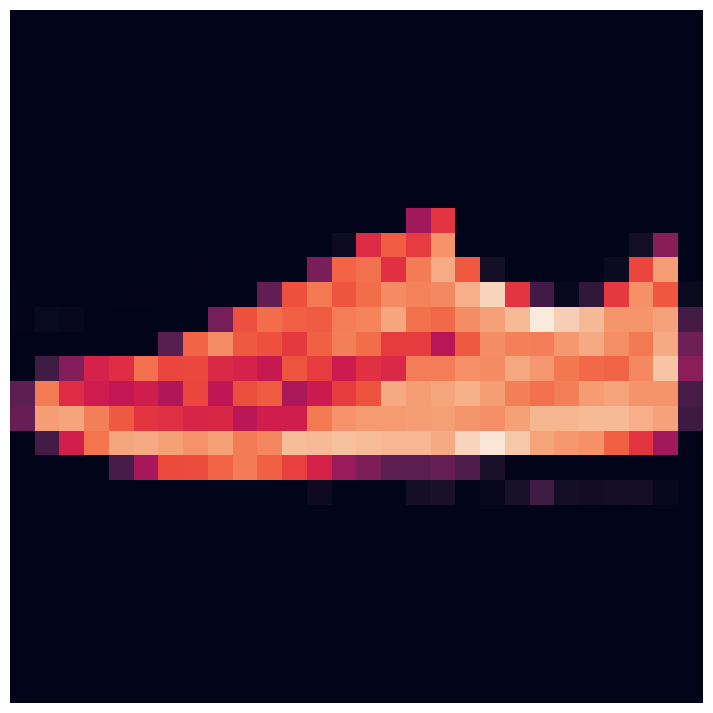

In [5]:
# reshaping one random picture
# 28, 28, 1 = H, W, C (C for channel number, here we have 1)
image = X[np.random.choice(np.arange(X.shape[0]))].reshape(28, 28, 1)
plt.imshow(image)
plt.axis("off");

### 1.1. Посмотрим на все классы (0.5 баллов)

Возьмите по одной картинке каждого класса и изобразите их (например, сделайте subplots 5 на 2).

**Labels** (cloth classes):

- 0 T-shirt/top
- 1 Trouser
- 2 Pullover
- 3 Dress
- 4 Coat
- 5 Sandal
- 6 Shirt
- 7 Sneaker
- 8 Bag
- 9 Ankle boot

In [6]:
# determing names for all cloth classes and indexes for the first their representatives
classes, class_indexes = np.unique(y, return_index=True)

In [7]:
# cloth classes names are from 0 to 9 (10 classes, as expected)
classes

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [8]:
# indexes for the first class representatives
class_indexes

array([ 2,  5,  8,  3, 34,  0, 18, 22, 13,  1])

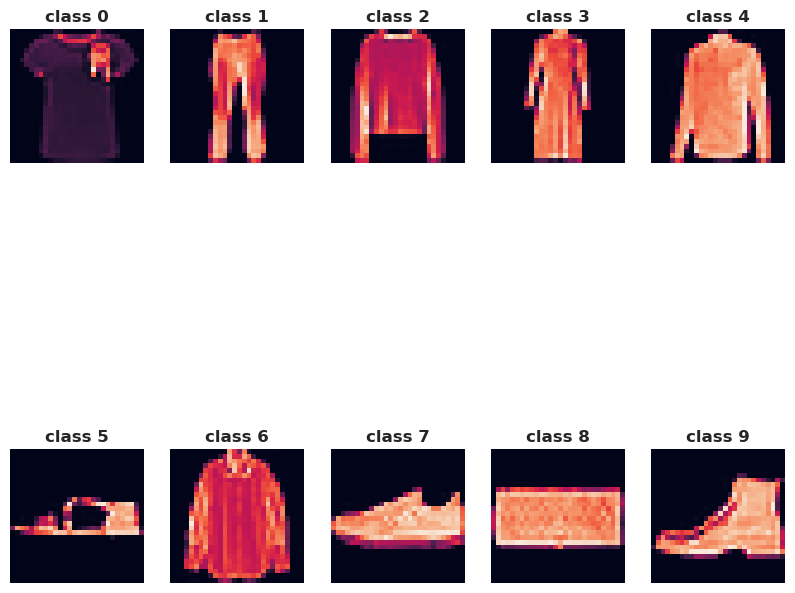

In [9]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(10, 10))

for cl, i, ax in zip(classes, class_indexes, axes.flat):
    class_repr = X[i].reshape(28, 28, 1)
    ax.imshow(class_repr)
    ax.axis("off")
    ax.set_title(f'class {cl}', 
                 fontsize=12, 
                 fontweight='bold')
    
plt.show();

### 1.2. Сделайте небольшой EDA (1 балл)

Посмотрите на баланс классов. В дальнейших домашках делайте EDA, когда считаете нужным, он нужен почти всегда, но оцениваться это уже не будет, если не будет указано иное. Делайте EDA, чтобы узнать что-то новое о данных!

In [10]:
unique_classes, counts = np.unique(y, return_counts=True)
counts_dict = dict(zip(unique_classes, counts))
counts_dict

{'0': 93,
 '1': 102,
 '2': 95,
 '3': 121,
 '4': 96,
 '5': 98,
 '6': 101,
 '7': 79,
 '8': 109,
 '9': 106}

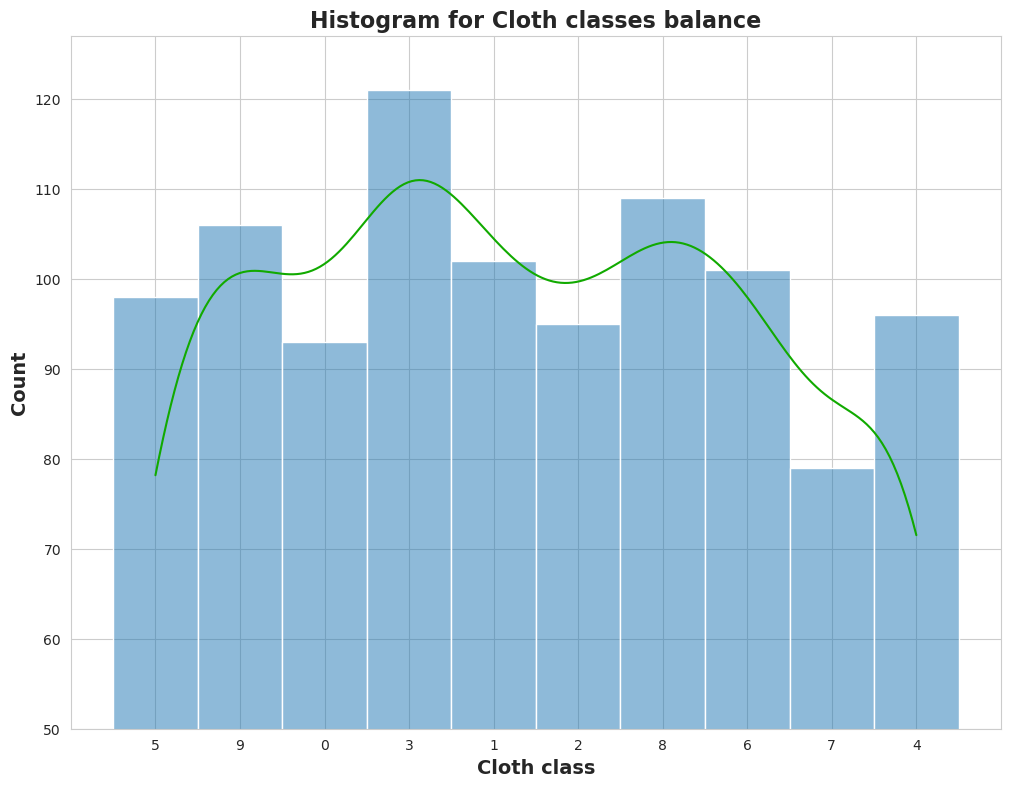

In [11]:
# histogram for classes balance
fig, ax = plt.subplots(1)

ax = sns.histplot(y, stat='count', kde=True)
ax.set_xlabel(xlabel='Cloth class', fontsize=14, fontweight='bold')
ax.set_ylabel(ylabel='Count', fontsize=14, fontweight='bold')
ax.set_title("Histogram for Cloth classes balance", fontsize=16, fontweight='bold')
ax.lines[0].set_color("#1a0")
ax.set_ylim(ymin=50)
sns.set_style(style='white');

plt.show()

It seems that cloth classes are balanced, though classes 3 and 7 a little bit outly.

### 1.3. Разделите данные на train и test (0.5 баллов)

Разделите данные на тренировочную и тестовую выборки, размеры тестовой выборки выберите сами. Здесь вам может помочь функция `train_test_split`

In [12]:
# for convenience, transforming y to type 'int32'
y = y.astype(int)

In [13]:
cloth_X_train, cloth_X_test, cloth_y_train, cloth_y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=SEED
)

In [14]:
cloth_data = {'cloth_X_train': cloth_X_train, 'cloth_X_test': cloth_X_test, 
              'cloth_y_train': cloth_y_train, 'cloth_y_test': cloth_y_test}
for name, data in cloth_data.items():
    data_shape = data.shape
    print(f'{name}: {data_shape}')

cloth_X_train: (750, 784)
cloth_X_test: (250, 784)
cloth_y_train: (750,)
cloth_y_test: (250,)


### 1.4. KNN для бинарной классификации (6 баллов)

Давайте возьмем для задачи бинарной классификации только объекты с метками классов 0 и 1.

In [15]:
# subset with 0 and 1 classes for train
binary_train_y = cloth_y_train[cloth_y_train < 2]
binary_train_X = cloth_X_train[cloth_y_train < 2]


# subset with 0 and 1 classes for test
binary_test_y = cloth_y_test[cloth_y_test < 2]
binary_test_X = cloth_X_test[cloth_y_test < 2]

In [16]:
# checking balance between 0 and 1 classes for binary classification
for data in (binary_train_y, binary_test_y):
    cl, counts = np.unique(data, return_counts=True)
    print(cl, counts)

[0 1] [72 74]
[0 1] [21 28]


И вот мы подготовили данные, но модели у нас пока что нет. В нескольких занятиях нашего курса вам придется самостоятельно реализовывать какие-то алгоритмы машинного обучения, а потом сравнивать их с готовыми библиотечными решениями. В остальных заданиях реализовывать алгоритмы будет не обязательно, но может быть полезно, поэтому часто это будут задания на дополнительные баллы, но главное не это, а понимание работы алгоритма после его реализации с нуля на простом numpy. Также это все потом можно оформить в виде репозитория ml_from_scratch и хвастаться перед друзьями.

In [17]:
knn_classifier = KNNClassifier(k=1)
knn_classifier.fit(binary_train_X, binary_train_y)

### Настало время писать код!

В KNN нам нужно для каждого тестового примера найти расстояния до всех точек обучающей выборки. Допустим у нас 1000 примеров в train'е и 100 в test'е, тогда в итоге мы бы хотели получить матрицу попарных расстояний (например, размерностью 100 на 1000). Это можно сделать несколькими способами, и кому-то наверняка, в голову приходит идея с двумя вложенными циклами (надеюсь, что не больше:). Так можно делать, то можно и эффективнее. Вообще, в реальном KNN используется структура данных [k-d-tree](https://ru.wikipedia.org/wiki/K-d-%D0%B4%D0%B5%D1%80%D0%B5%D0%B2%D0%BE), которая позволяет производить поиск за log(N), а не за N, как будем делать мы (по сути это такое расширение бинарного поиска на многомерное пространство).

Вам нужно будет последовательно реализовать методы `compute_distances_two_loops`, `compute_distances_one_loop` и `compute_distances_no_loops` класса `KNN` в файле `knn.py`.

Эти функции строят массив расстояний между всеми векторами в тестовом наборе и в тренировочном наборе.  
В результате они должны построить массив размера `(num_test, num_train)`, где координата `[i][j]` соотвествует расстоянию между i-м вектором в test (`test[i]`) и j-м вектором в train (`train[j]`).

**Обратите внимание** Для простоты реализации мы будем использовать в качестве расстояния меру L1 (ее еще называют [Manhattan distance](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D1%81%D0%BA%D0%B8%D1%85_%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B0%D0%BB%D0%BE%D0%B2)).

$d_{1}(\mathbf {p} ,\mathbf {q} )=\|\mathbf {p} -\mathbf {q} \|_{1}=\sum _{i=1}^{n}|p_{i}-q_{i}|$

В начале я буду иногда писать разные assert'ы, чтобы можно было проверить правильность реализации, в дальнейшем вам нужно будет их писать самим, если нужно будет проверять корректность каких-то вычислений.

In [18]:
# TODO: compute_distances_two_loops
dists = knn_classifier.compute_distances_two_loops(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))

In [19]:
# TODO: compute_distances_one_loop
dists = knn_classifier.compute_distances_one_loop(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))

In [20]:
# TODO: compute_distances_no_loops
dists = knn_classifier.compute_distances_no_loops(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))

Проверим скорость работы реализованных методов

In [21]:
%timeit knn_classifier.compute_distances_two_loops(binary_test_X)
%timeit knn_classifier.compute_distances_one_loop(binary_test_X)
%timeit knn_classifier.compute_distances_no_loops(binary_test_X)

29.2 ms ± 1.51 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
3.84 ms ± 78.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
24.1 ms ± 1.89 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Реализуем метод для предсказания меток класса

In [22]:
# TODO: predict_labels_binary in knn.py
prediction = knn_classifier.predict(binary_test_X)

### Метрика

Теперь нужно реализовать несколько метрик для бинарной классификации. Не забудьте подумать о численной нестабильности (деление на 0).

In [23]:
# TODO: binary_classification_metrics in metrics.py

In [24]:
metrics = ['precision_score', 'recall_score', 'f1_score', 'accuracy_score']
bin_class_metrics = binary_classification_metrics(prediction, binary_test_y)
for metric, value in zip(metrics, bin_class_metrics):
    print(f'{metric}: {value}')

precision_score: 1.0
recall_score: 1.0
f1_score: 1.0
accuracy_score: 1.0


Все ли хорошо с моделью? Можно проверить свою реализацию с функциями из библиотеки `sklearn`:

<img src="https://i.imgflip.com/406fu9.jpg" width="800" height="400">

In [25]:
# checking prediction metrics using sklearn
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
sklearn_metrics = [precision_score, recall_score, f1_score, accuracy_score]
for metric in sklearn_metrics:
    value = metric(binary_test_y, prediction) 
    print(f'{metric.__name__}: {value}')

precision_score: 1.0
recall_score: 1.0
f1_score: 1.0
accuracy_score: 1.0


Hmm, looks strange but heh.

### Подбор оптимального k

Чтобы подрбрать оптимальное значение параметра k можно сделать следующее: задать область допустимых значений k, например, `[1, 3, 5, 10]`. Дальше для каждого k обучить модель на тренировочных данных, сделать предсказания на тестовых и посчитать какую-нибудь метрику (метрику выберите сами исходя из задачи, но постарайтесь обосновать выбор). В конце нужно посмотреть на зависимость метрики на train'е и test'е от k и выбрать подходящее значение.

Реализуйте функцию `choose_best_k` прямо в ноутбуке.

In [26]:
# with my functions
def find_best_k(X_train, y_train, X_test, y_test, params):
    """
    Choose the best k for KKNClassifier
    Arguments:
    X_train, np array (num_train_samples, num_features) - train data
    y_train, np array (num_train_samples) - train labels
    X_test, np array (num_test_samples, num_features) - test data
    y_test, np array (num_test_samples) - test labels
    params, list of hyperparameters for KNN, here it is list of k values
    
    Returns:
    train_metrics the list of metric values on train data set for each k in params
    test_metrics the list of metric values on test data set for each k in params
    """
    
    
    np.random.seed(SEED)
    train_metrics = pd.DataFrame(columns=["precision", "recall", "f1", "accuracy"])
    test_metrics = pd.DataFrame(columns=["precision", "recall", "f1", "accuracy"])
    
    for i, k in enumerate(params):
        knn_classifier = KNNClassifier(k=k)
        knn_classifier.fit(X_train, y_train)
        
        # training model
        train_prediction = knn_classifier.predict(X_train)
        # testing model
        test_prediction = knn_classifier.predict(X_test)    
 
        # train model metrics
        train_met = binary_classification_metrics(train_prediction, y_train)
        train_metrics.loc[i] = train_met

        # test model metrics
        test_met = binary_classification_metrics(test_prediction, y_test)
        test_metrics.loc[i] = test_met
    return train_metrics, test_metrics

In [27]:
params = range(1, 31)
train_metrics, test_metrics = find_best_k(binary_train_X, binary_train_y, binary_test_X, binary_test_y, params)

In [28]:
train_metrics.head()

,precision,recall,f1,accuracy
0,1.0,1.000000,1.000000,1.000000
1,1.0,1.000000,1.000000,1.000000
2,1.0,1.000000,1.000000,1.000000
3,1.0,0.986486,0.993197,0.993151
4,1.0,0.986486,0.993197,0.993151


In [29]:
test_metrics.head()

,precision,recall,f1,accuracy
0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0


Sooo, according to prediction metrics... this model is good for binary classification. Let's visualize prediction metrics.

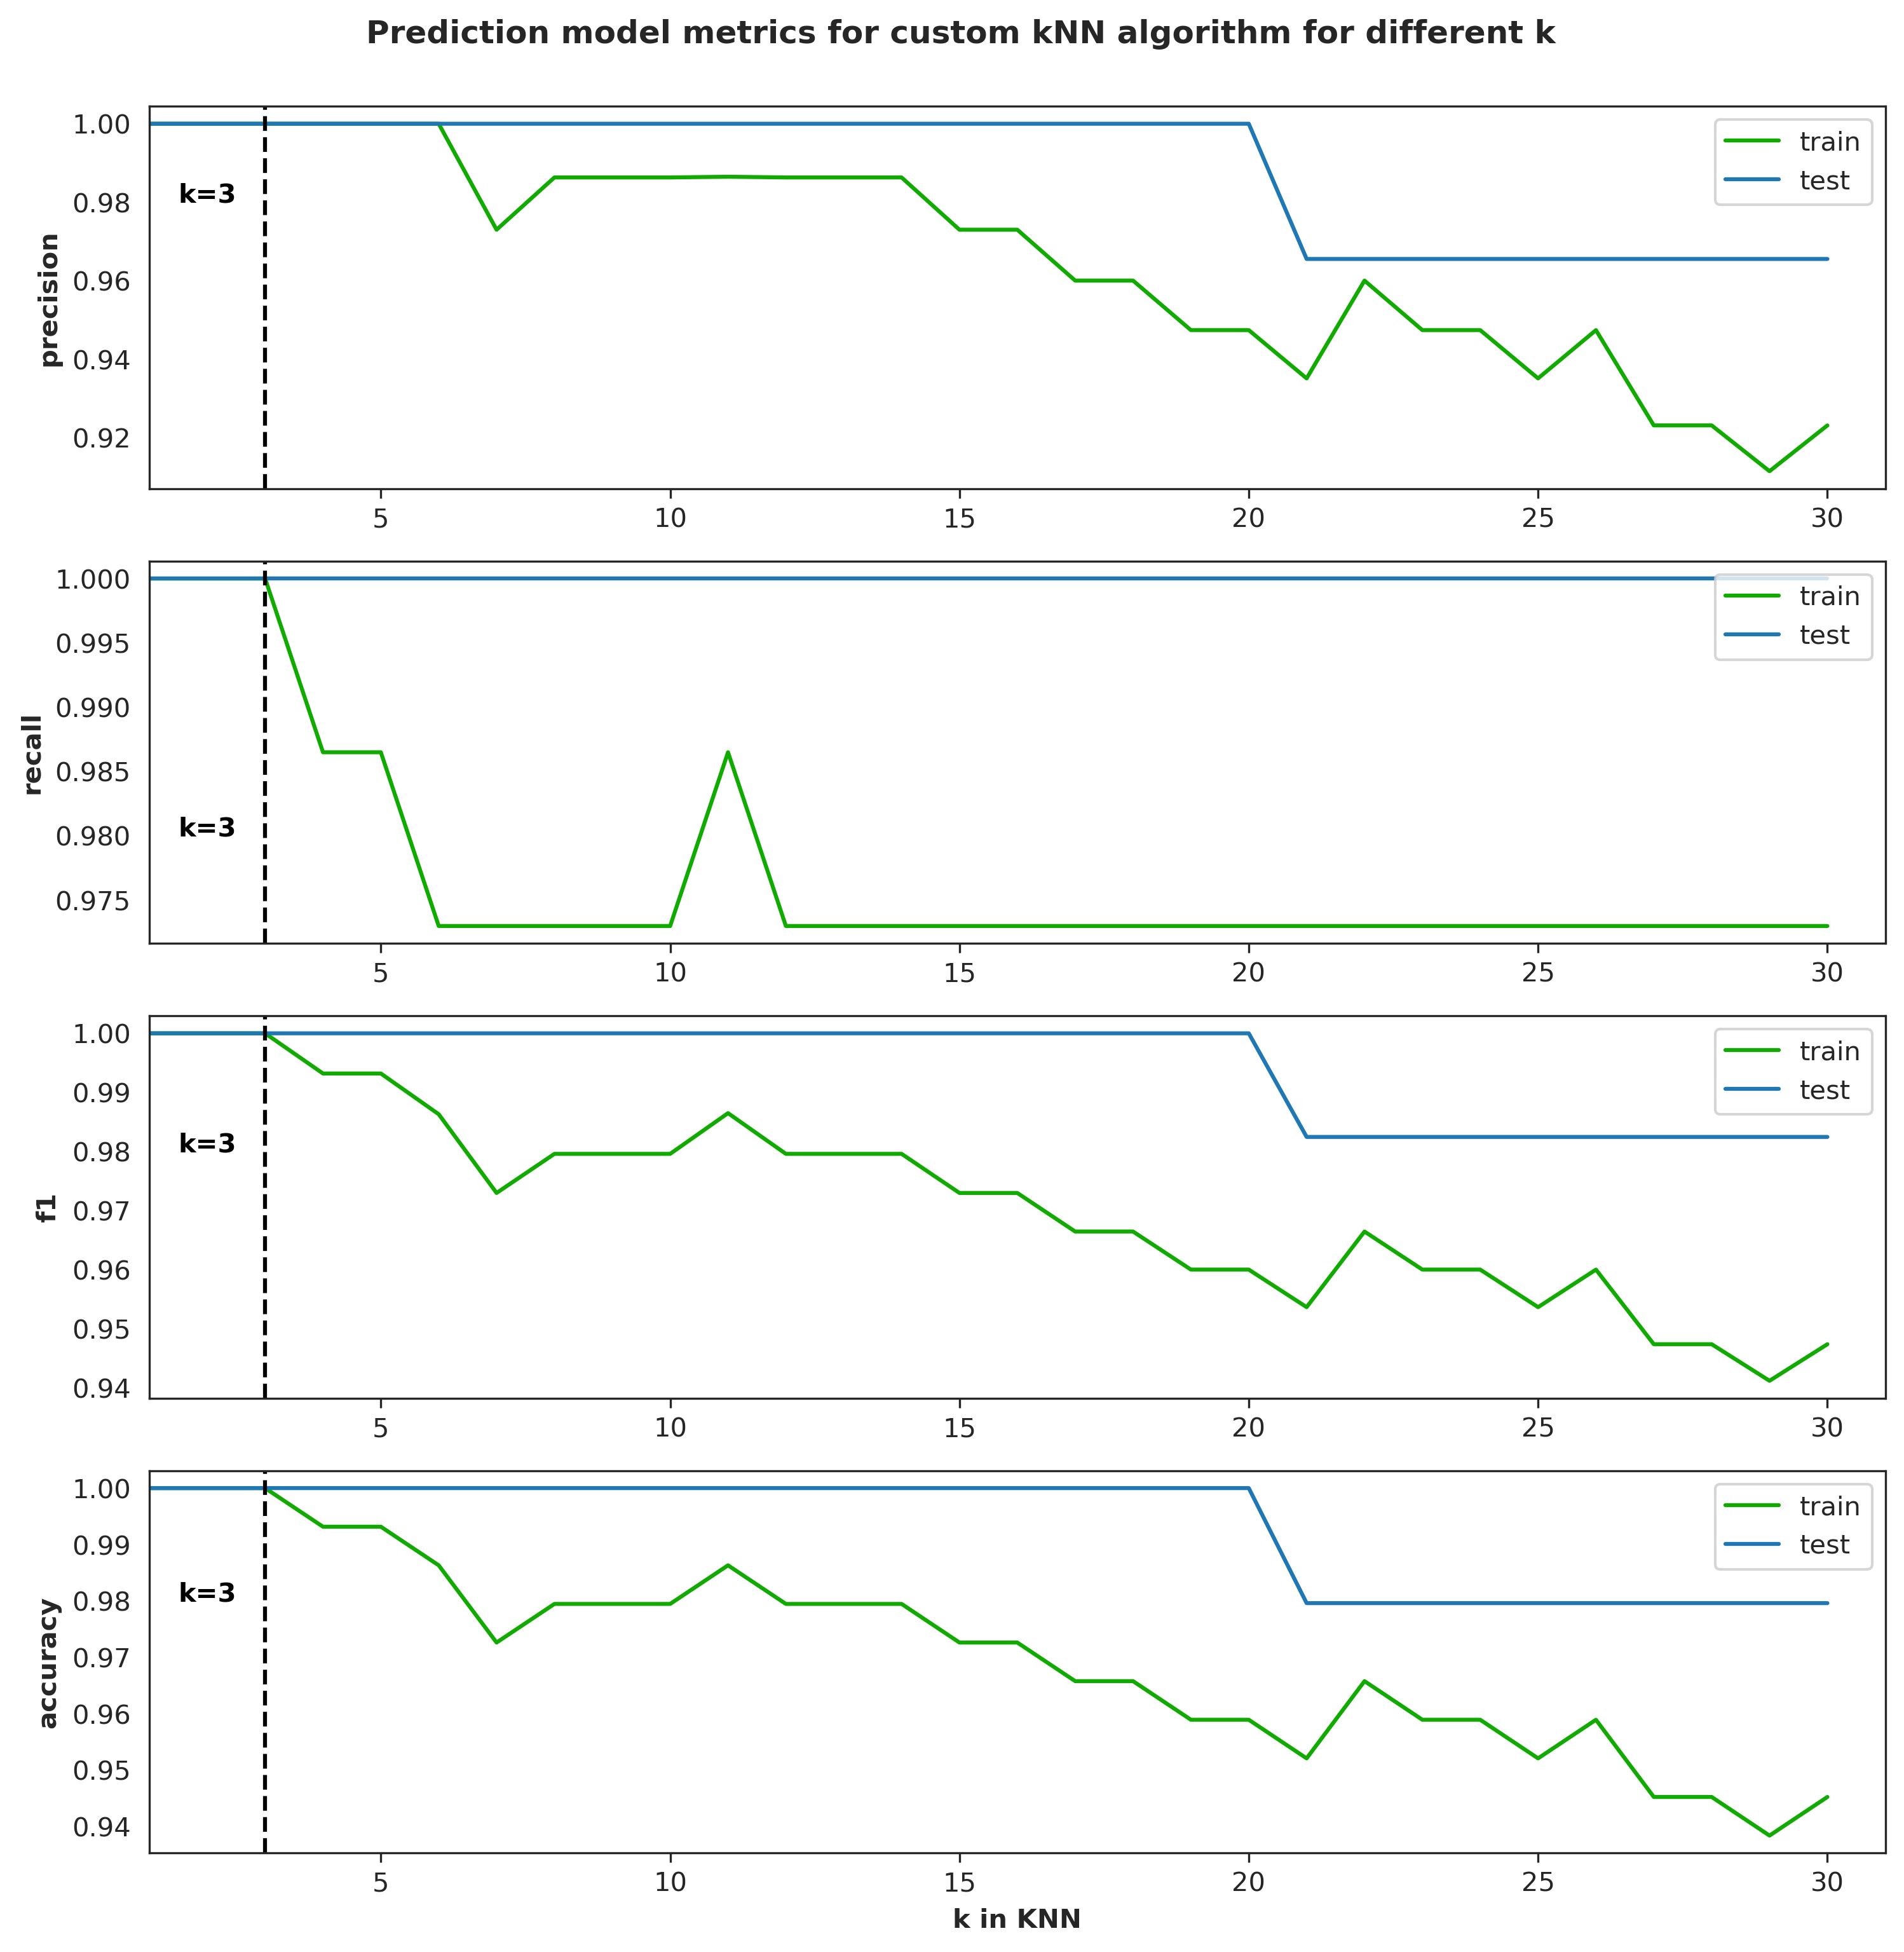

In [30]:
fig, axes = plt.subplots(ncols=1, nrows=4, figsize=(10, 10), dpi=300)
fig.suptitle("Prediction model metrics for custom kNN algorithm for different k", fontsize=12, fontweight='bold', y=1)    
fig.subplots_adjust(hspace=0.5)

for metric, ax in zip(train_metrics.columns, axes.flat):
    ax.plot(params, train_metrics[metric], label="train", color="#1a0")
    ax.plot(params, test_metrics[metric], label="test")
    ax.set_ylabel(metric, fontweight='bold')
    ax.tick_params(axis='x', bottom=True)
    ax.axvline(x=3, color = 'black', linestyle='--')
    ax.set_xlim(1, 31)
    ax.legend(loc='upper right')
    ax.text(x=1.5, y=0.98, s="k=3", fontdict={'fontsize': 10, 'fontweight': 'bold', 'color': 'black'})

plt.tight_layout()
plt.xlabel("k in KNN", fontweight='bold')
plt.show();

It looks strange that kNN model predicts better for test dataset. I decided to compare rersults with sklearn metrics. 

In [31]:
def sk_find_best_k(X_train, y_train, X_test, y_test, params):
    train_metrics = pd.DataFrame(columns=["precision", "recall", "accuracy", "f1"])
    test_metrics = pd.DataFrame(columns=["precision", "recall", "accuracy", "f1"])

    for i, k in enumerate(params):
        knn_model = KNeighborsClassifier(n_neighbors=k, n_jobs=16, metric="manhattan")
        knn_model.fit(X_train, y_train)

        # training model
        train_prediction = knn_model.predict(X_train)
        pr = precision_score(y_train, train_prediction)
        rc = recall_score(y_train, train_prediction)
        acc = accuracy_score(y_train, train_prediction)
        f1 = f1_score(y_train, train_prediction)
        train_metrics.loc[i] = [pr, rc, f1, acc]
        
        # testing model
        test_prediction = knn_model.predict(X_test)
        pr = precision_score(y_test, test_prediction)
        rc = recall_score(y_test, test_prediction)
        acc = accuracy_score(y_test, test_prediction)
        f1 = f1_score(y_test, test_prediction)
        test_metrics.loc[i] = [pr, rc, f1, acc]
        
    return train_metrics, test_metrics

In [32]:
%%capture --no-display

params = range(1, 31)
train_metrics_sk, test_metrics_sk = sk_find_best_k(binary_train_X, binary_train_y, binary_test_X, binary_test_y, params);

In [33]:
test_metrics_sk.head()

,precision,recall,accuracy,f1
0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0


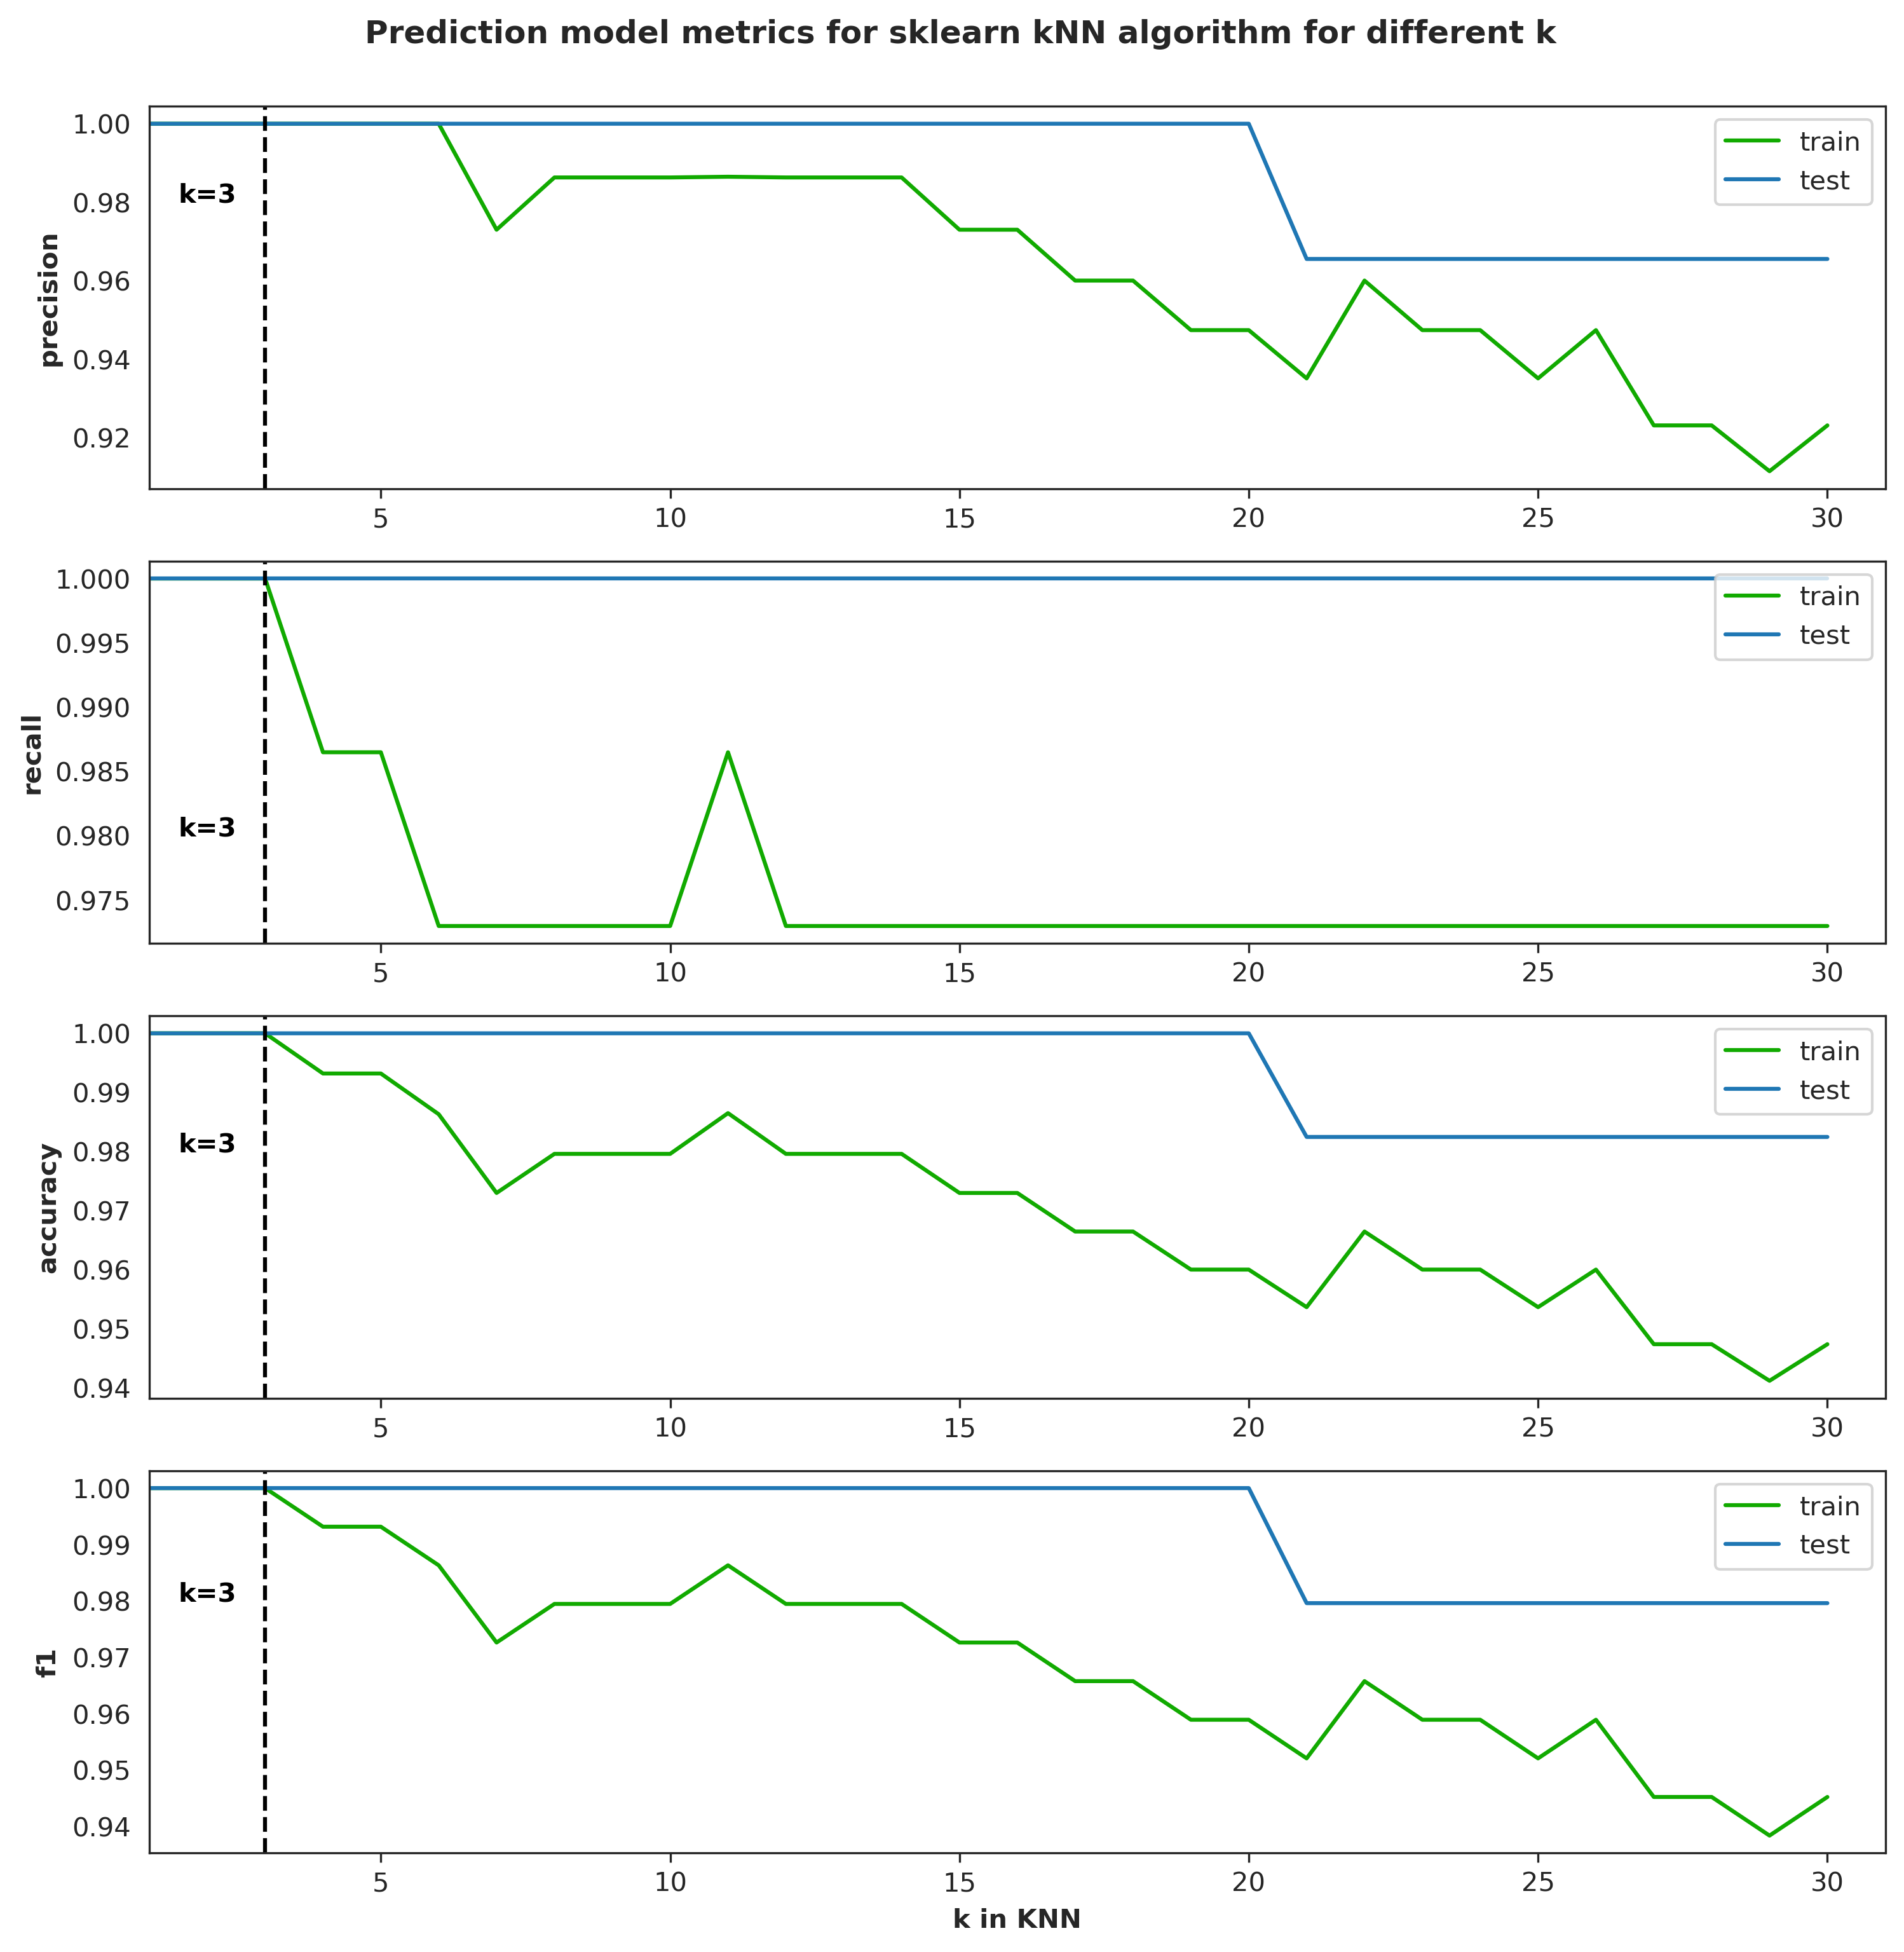

In [34]:
fig, axes = plt.subplots(ncols=1, nrows=4, figsize=(10, 10), dpi=300)
fig.suptitle("Prediction model metrics for sklearn kNN algorithm for different k", fontsize=12, fontweight='bold', y=1)    
fig.subplots_adjust(hspace=0.5)

for metric, ax in zip(train_metrics_sk.columns, axes.flat):
    ax.plot(params, train_metrics_sk[metric], label="train", color="#1a0")
    ax.plot(params, test_metrics_sk[metric], label="test")
    ax.set_ylabel(metric, fontweight='bold')
    ax.tick_params(axis='x', bottom=True)
    ax.axvline(x=3, color = 'black', linestyle='--')
    ax.set_xlim(1, 31)
    ax.legend(loc='upper right')
    ax.text(x=1.5, y=0.98, s="k=3", fontdict={'fontsize': 10, 'fontweight': 'bold', 'color': 'black'})

plt.tight_layout()
plt.xlabel("k in KNN", fontweight='bold')
plt.show();

**Conclusions:**

- *Which metrics to choose?*

False positives and false negatives are less significant in this context since both measures are equally relevant. I think accuracy score is more convenient in this case for taking into account both true negatives and true positives predictions.

- *Which number of neighbors (*k*) should be chosen?*

I prefer to use three neighbors for kNN since, according to the data from the custom and sklearn algorithms, the accuracy score is the highest for test values and train values with *k=1-6* and *k=1-3*, respectively. Though, *k=1-20* is equally good for test values.

На самом деле, это не самый лучший способ подбирать гиперпараметры, но способы получше мы рассмотрим в следующий раз, а пока что выберите оптимальное значение k, сделайте предсказания и посмотрите, насколько хорошо ваша модель предсказывает каждый из классов.

### 1.5. Многоклассоввая классификация (2 балла)

Теперь нужно научиться предсказывать все 10 классов. Для этого в начале напишем соответствующий метод у нашего классификатора.

In [35]:
# TODO: predict_labels_multiclass in knn.py
knn_classifier = KNNClassifier(k=1)
knn_classifier.fit(cloth_X_train, cloth_y_train)
predictions = knn_classifier.predict(cloth_X_test)

Осталось реализовать метрику качества для многоклассовой классификации, для этого реализуйте функцию `multiclass_accuracy` в `metrics.py`.

In [36]:
# TODO: multiclass_accuracy in metrics.py
multiclass_accuracy(predictions, cloth_y_test)

0.764

Снова выберите оптимальное значение K как мы делали для бинарной классификации.

In [37]:
def find_best_k_multi(X_train, y_train, X_test, y_test, params):
    np.random.seed(SEED)
    train_multi_accuracy = []
    test_multi_accuracy = []
    
    for k in params:
        knn_classifier = KNNClassifier(k=k)
        knn_classifier.fit(X_train, y_train)
        
        # training model
        train_prediction = knn_classifier.predict(X_train)
        # testing model
        test_prediction = knn_classifier.predict(X_test)
        
        # accuracy for train
        train_acc = multiclass_accuracy(train_prediction, y_train)
        # print(train_acc)
        train_multi_accuracy.append(train_acc)
        
        # accuracy for test
        test_acc = multiclass_accuracy(test_prediction, y_test)
        # print(test_acc)
        test_multi_accuracy.append(test_acc)
    return train_multi_accuracy, test_multi_accuracy

In [38]:
params = range(1, 31)
train_multi_accuracy, test_multi_accuracy = find_best_k_multi(cloth_X_train, cloth_y_train, cloth_X_test, cloth_y_test, params)

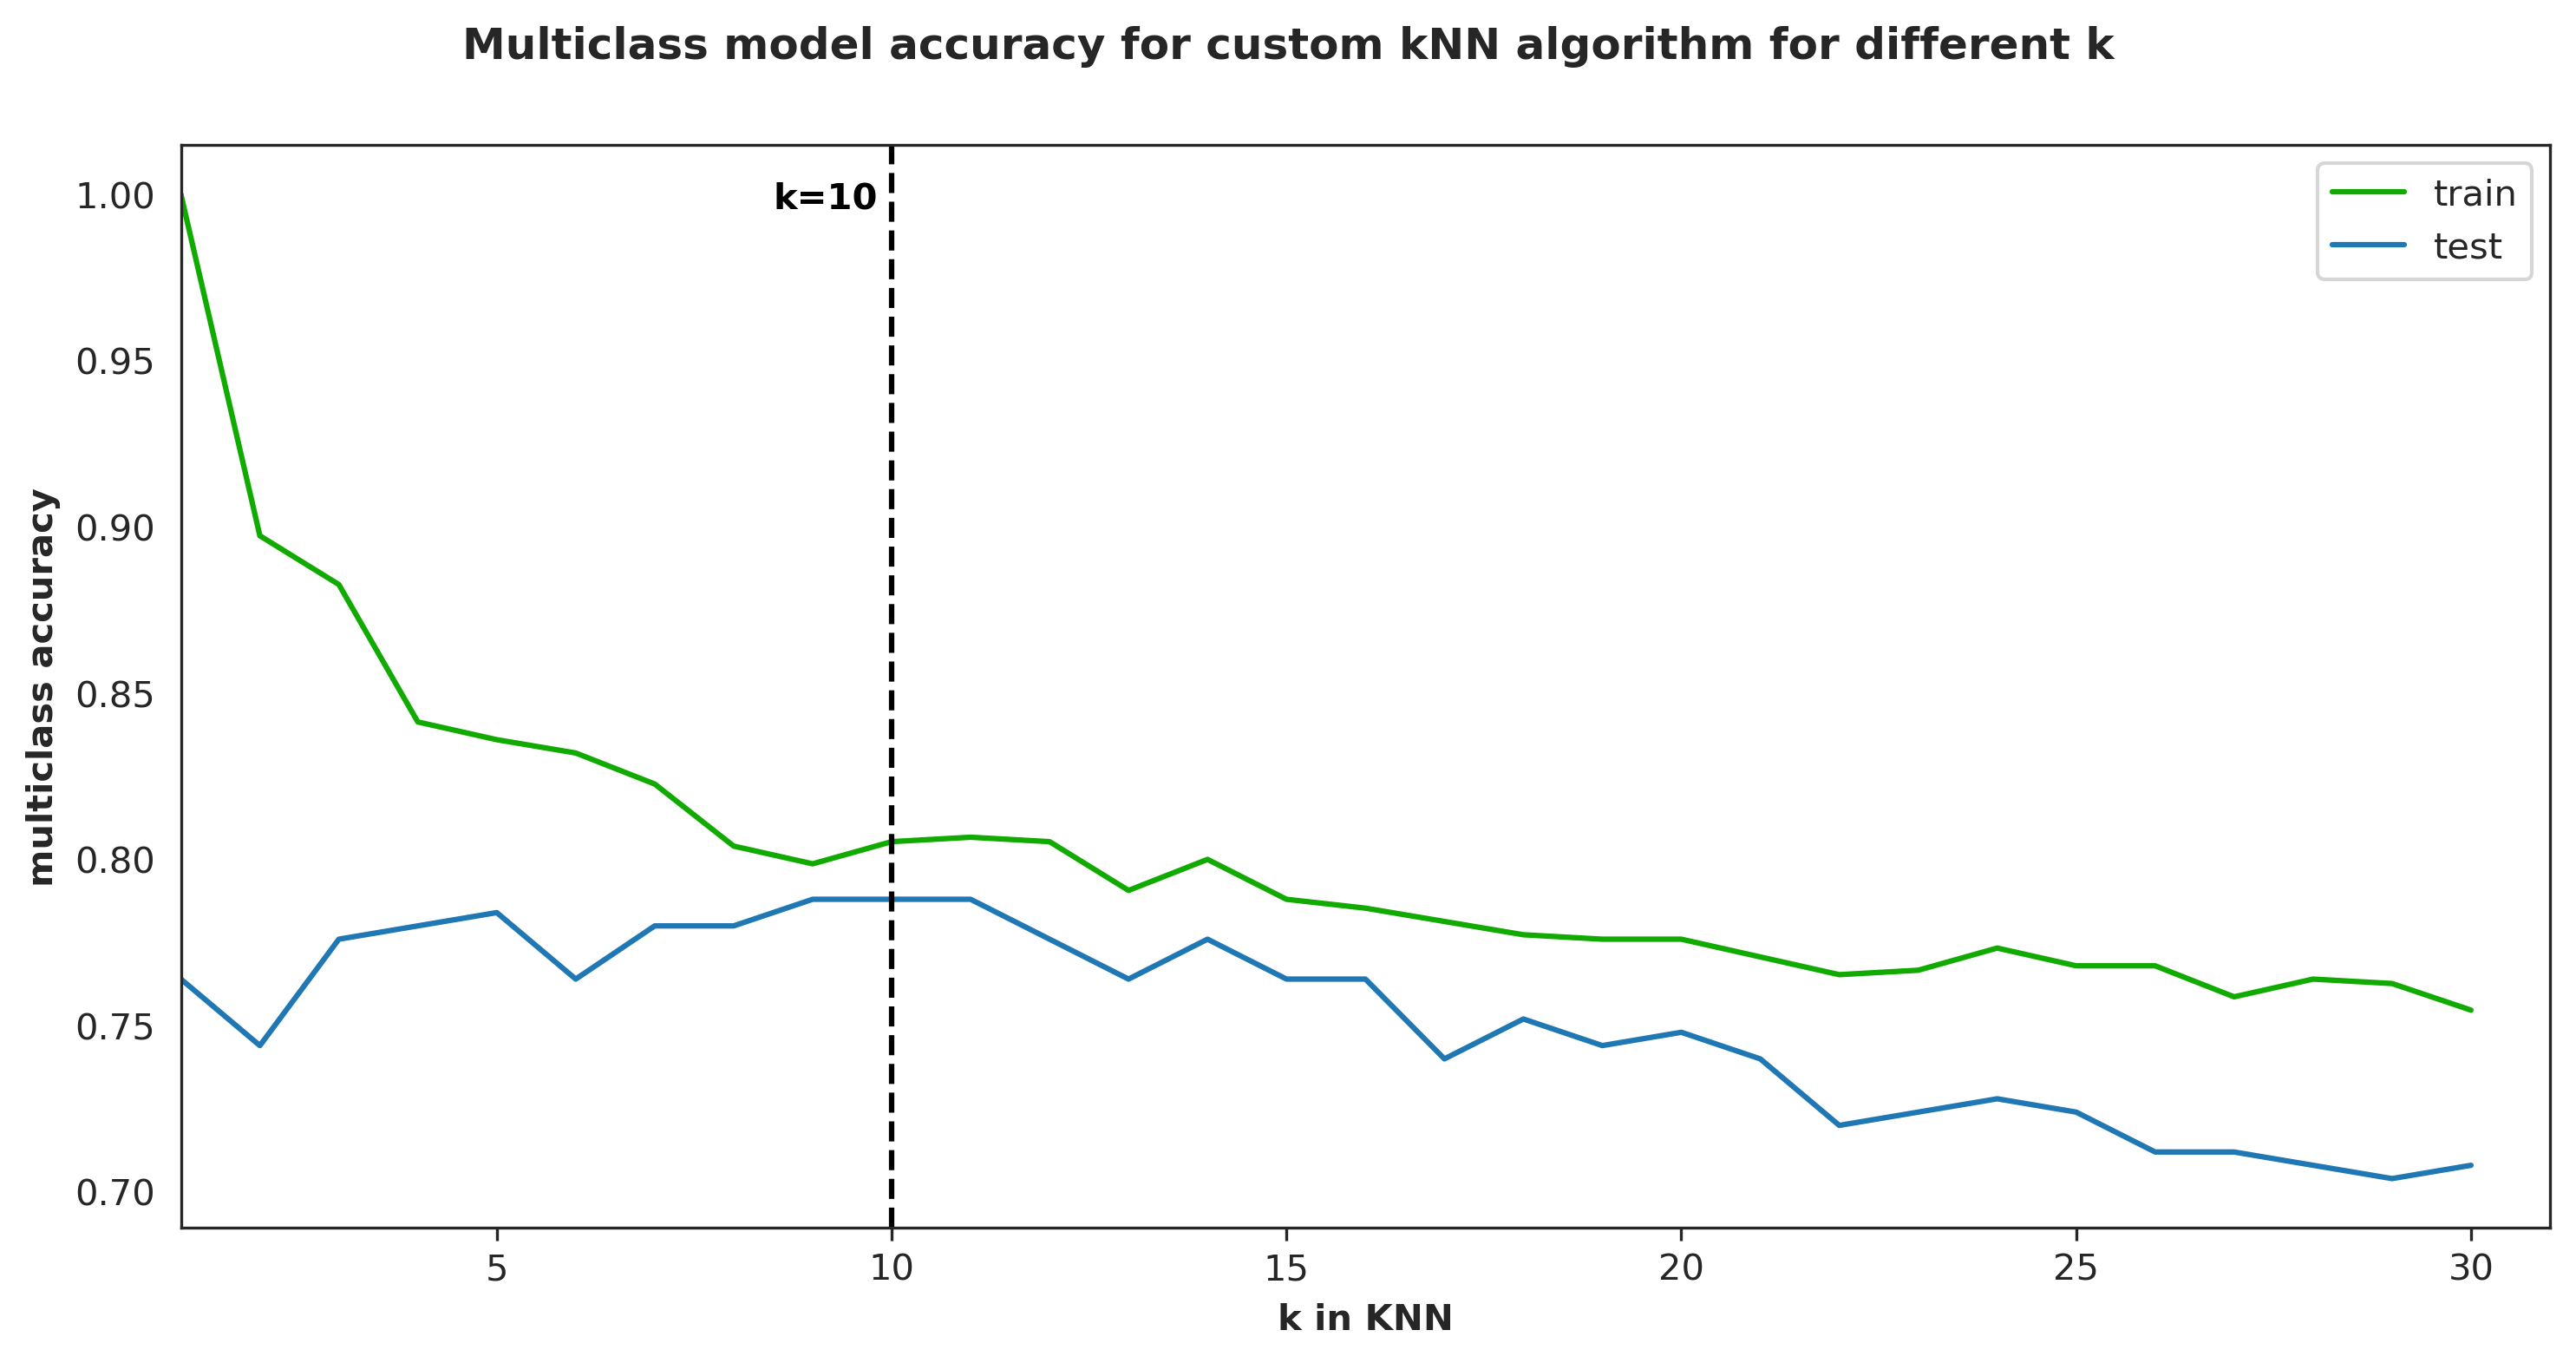

In [39]:
fig, ax = plt.subplots(1, figsize=(10, 5), dpi=300)
fig.suptitle("Multiclass model accuracy for custom kNN algorithm for different k", fontsize=12, fontweight='bold', y=1)    

ax.plot(params, train_multi_accuracy, label="train", color="#1a0")
ax.plot(params, test_multi_accuracy, label="test")
ax.set_ylabel("multiclass accuracy", fontweight='bold')
ax.tick_params(axis='x', bottom=True)
ax.axvline(x=10, color = 'black', linestyle='--')
ax.set_xlim(1, 31)
ax.legend(loc='upper right')
ax.text(x=8.5, y=0.996, s="k=10", fontdict={'fontsize': 10, 'fontweight': 'bold', 'color': 'black'})

plt.tight_layout()
plt.xlabel("k in KNN", fontweight='bold')
plt.show();

**Conclusions:**

- *Which number of neighbors (*k*) should be chosen?*

I prefer to use ten neighbors for kNN since, according to the data from the custom algorithms, the accuracy score is the highest for test X values. Also, it should be mentioned that accuracy score is the highest for test data in range *k=9-11* neighbors.

## Задание 2. KNN на датасете diabetes (10 баллов)

Теперь попробуем применить KNN к задаче регрессии. Будем работать с [данными](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset) о диабете. В этом задании будем использовать класс `KNeighborsRegressor` из библиотеки `sklearn`. Загрузим необходимые библиотеки:

In [40]:
from sklearn.datasets import load_diabetes
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import (StandardScaler,
                                   OneHotEncoder)
from metrics import r_squared, mse, mae

from sklearn.compose import ColumnTransformer

In [41]:
X, y = load_diabetes(as_frame=True, return_X_y=True)

In [43]:
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


In [43]:
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


### 2.1. EDA (2 обязательных балла + 2 доп. балла за Pipeline)

Сделайте EDA, предобработайте данные так, как считаете нужным, нужна ли в данном случае стандартизация и почему? Не забудте, что если вы стандартизуете данные, то нужно считать среднее и сдандартное отклонение на тренировочной части и с помощью них трансформировать и train, и test (**если не поняли это предложение, то обязательно разберитесь**).

**Дополнительно**:
Попробуйте разобраться с [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html), чтобы можно было создать класс, который сразу проводит стандартизацию и обучает модель (или делает предсказание). Пайплайны очень удобны, когда нужно применять различные методы предобработки данных (в том числе и к разным столбцам), а также они позволяют правильно интегрировать предобработку данных в различные классы для поиска наилучших гиперпараметров модели (например, `GridSearchCV`).

1) Let's obtain overall description for X and y.

In [44]:
# description for X
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
dtypes: float64(10)
memory usage: 34.7 KB


In [45]:
# description for y
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 442 entries, 0 to 441
Series name: target
Non-Null Count  Dtype  
--------------  -----  
442 non-null    float64
dtypes: float64(1)
memory usage: 3.6 KB


In [46]:
# X and y sizes
X.shape, y.shape

((442, 10), (442,))

2) Let's take a look on mean and std for all features and target

In [47]:
X.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02
mean,-3.634285e-16,1.308343e-16,-8.045349e-16,1.281655e-16,-8.835316e-17,1.327024e-16,-4.574646e-16,3.777301e-16,-3.830854e-16,-3.412882e-16
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123996e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260974e-01,-1.377672e-01
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665645e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324879e-02,-3.317903e-02
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670611e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947634e-03,-1.077698e-03
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564384e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243323e-02,2.791705e-02
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320442e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335990e-01,1.356118e-01


It seems that features were previously standardized (or something else?). The std seems to be the same, and mean is almost zero. Although, I prefer to standardize features just in case and for training too.

Also, strange values for categorial feature *sex*, but still binary.

In [48]:
y.describe()

count    442.000000
mean     152.133484
std       77.093005
min       25.000000
25%       87.000000
50%      140.500000
75%      211.500000
max      346.000000
Name: target, dtype: float64

3) Let's visualize distribution for both features and tar

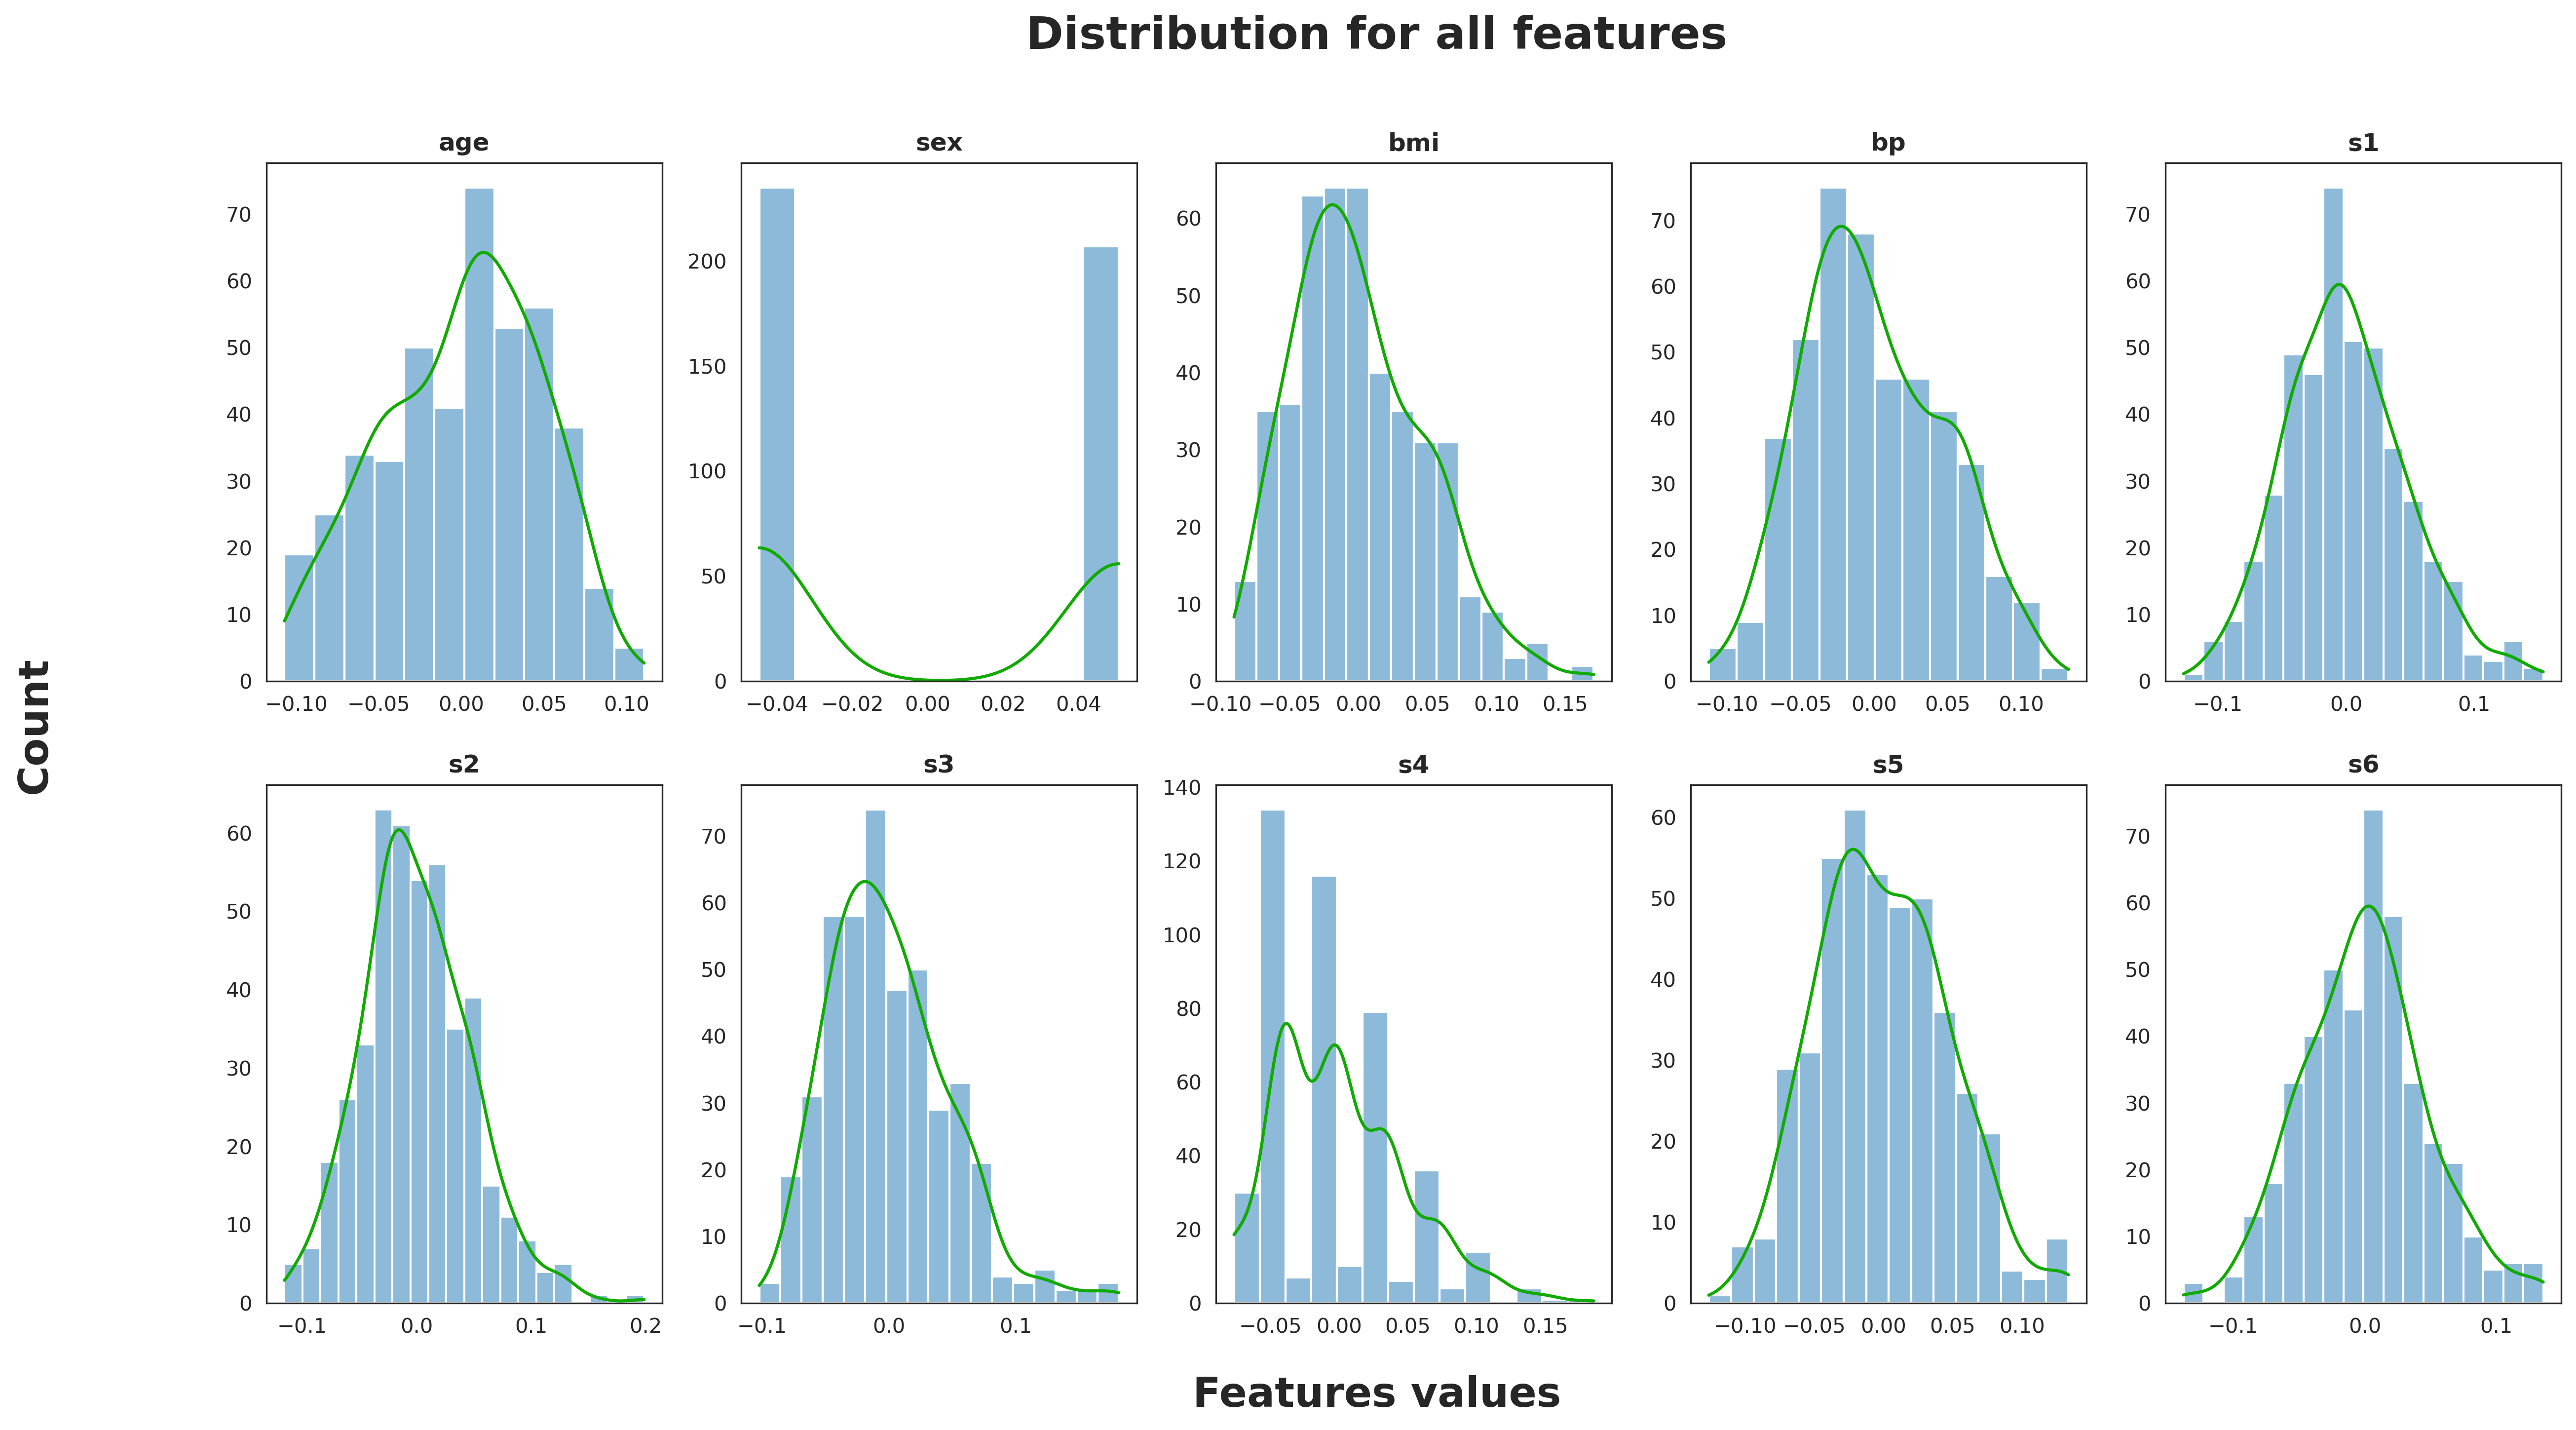

In [49]:
## histplot for all features
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(20, 10), dpi=300)

for i, ax in zip(range(10), axes.flat):
    sns.histplot(X.iloc[:, i], kde=True, ax=ax)
    ax.set(xlabel='', ylabel='')
    ax.set_title(X.columns[i], fontsize=12, fontweight='bold')
    ax.lines[0].set_color("#1a0")
    
fig.suptitle("Distribution for all features", fontsize=22, fontweight="bold")
fig.text(0.5, 0.04, 'Features values', ha='center', 
         fontsize=20, fontweight='bold')
fig.text(0.04, 0.5, 'Count', va='center', 
         rotation='vertical', fontsize=20, fontweight='bold')

plt.show();

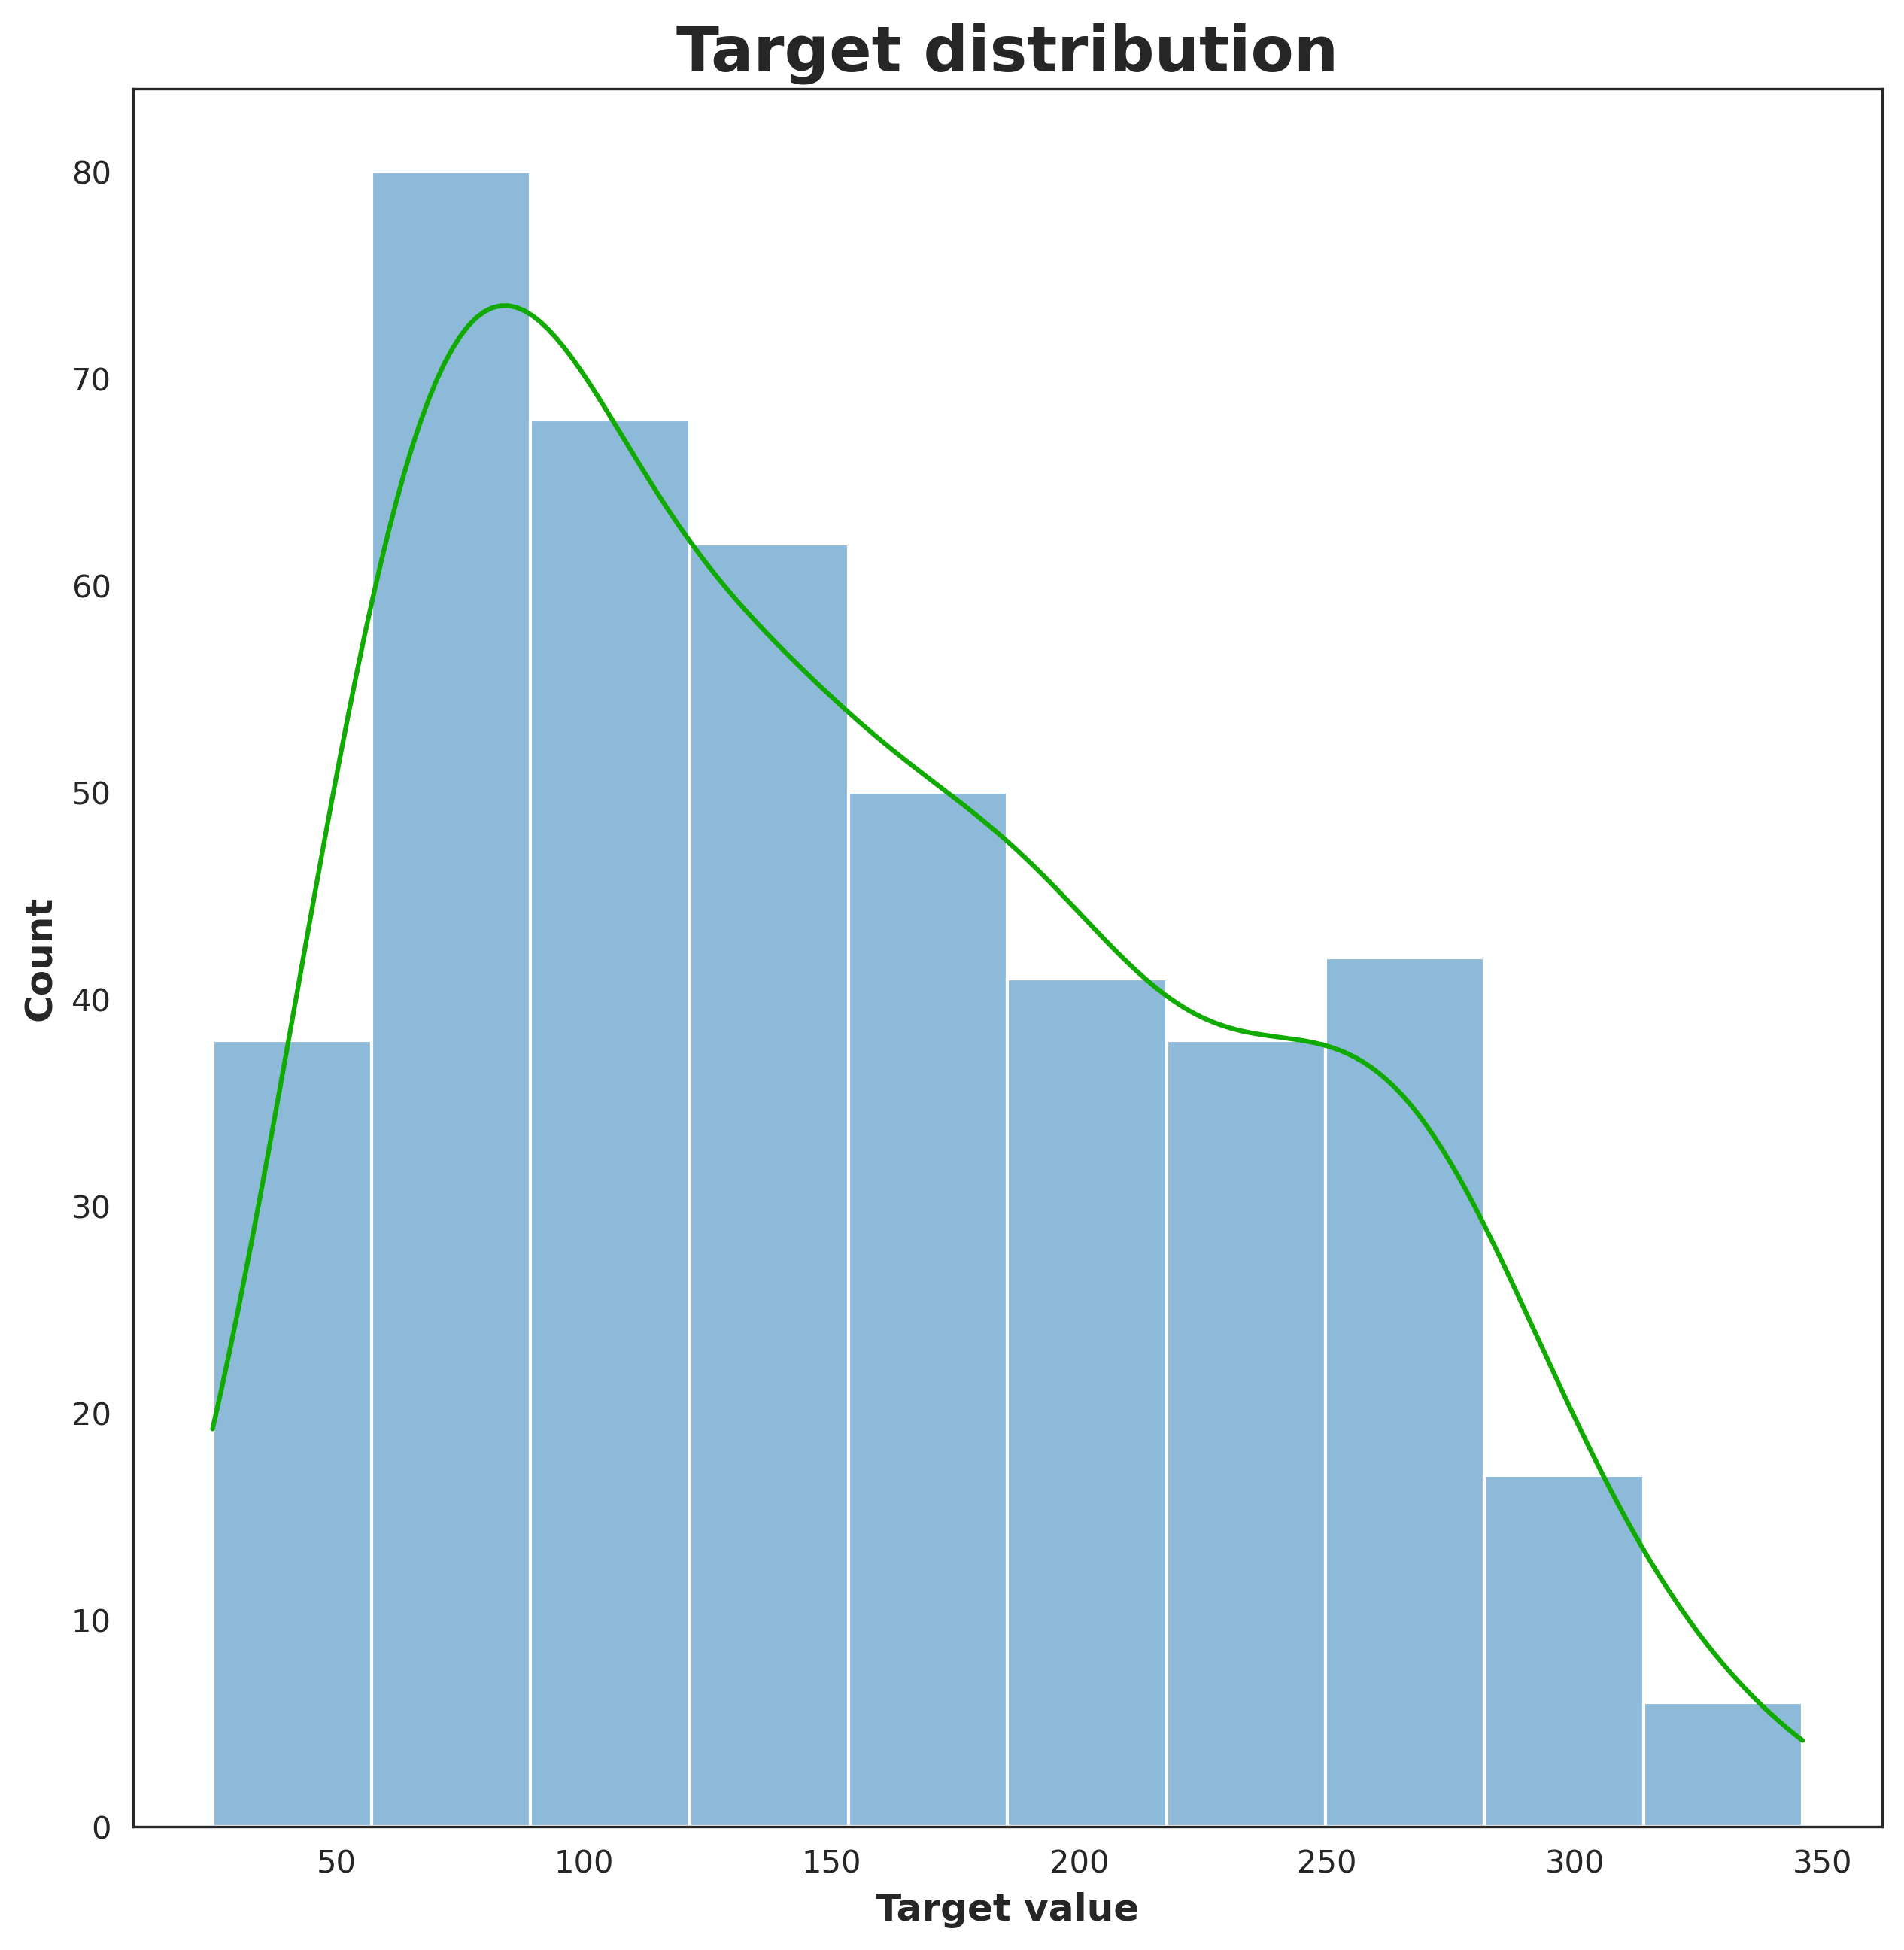

In [50]:
# histplot for target
fig, ax = plt.subplots(1, figsize=(10, 10), dpi=300)
sns.histplot(y, kde=True, ax=ax)
ax.set_xlabel('Target value', fontsize=12, fontweight="bold")
ax.set_ylabel('Count', fontsize=12, fontweight="bold")
ax.set_title("Target distribution", fontsize=20, fontweight='bold')
ax.lines[0].set_color("#1a0")

4) Finally, let's check the presence of Nan and zeros in dataset

In [51]:
# Nan in X
np.sum(X.isna())

age    0
sex    0
bmi    0
bp     0
s1     0
s2     0
s3     0
s4     0
s5     0
s6     0
dtype: int64

In [52]:
# null in X
np.sum(X.isnull())

age    0
sex    0
bmi    0
bp     0
s1     0
s2     0
s3     0
s4     0
s5     0
s6     0
dtype: int64

In [53]:
# Nan in y
np.sum(X.isna())

age    0
sex    0
bmi    0
bp     0
s1     0
s2     0
s3     0
s4     0
s5     0
s6     0
dtype: int64

In [54]:
# null in y
np.sum(X.isnull())

age    0
sex    0
bmi    0
bp     0
s1     0
s2     0
s3     0
s4     0
s5     0
s6     0
dtype: int64

Neigher Nan nor null observations in both X and y. 

### 2.2. Регрессионная модель (1 балл)

Создайте модель `KNeighborsRegressor`, обучите ее на треноровочных данных и сделайте предсказания.

In [55]:
cat_col = ["sex"]
num_cols = ["age", "bmi", "bp", "s1", "s2", "s3", "s4", "s5", "s6"]

In [56]:
# spliting train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((353, 10), (353,), (89, 10), (89,))

In [57]:
# standardizing features
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [58]:
# formating cat feature
ohe = OneHotEncoder(sparse=False, drop="first")
X_train[cat_col] = ohe.fit_transform(X_train[cat_col])
X_test[cat_col] = ohe.transform(X_test[cat_col])

In [59]:
# fitting model
neigh_model = KNeighborsRegressor(n_neighbors=1, n_jobs=4, metric="manhattan")
neigh_model.fit(X_train, y_train)
prediction = neigh_model.predict(X_test)

#### With Pipeline

In [60]:
preprocessor = ColumnTransformer(transformers=[
    ("scaler", StandardScaler(), num_cols),
    ("ohe", OneHotEncoder(drop="first"), cat_col)
])

In [61]:
preprocessor.transformers

[('scaler',
  StandardScaler(),
  ['age', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']),
 ('ohe', OneHotEncoder(drop='first'), ['sex'])]

In [62]:
# with k=1
knn_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("knn", KNeighborsRegressor(n_neighbors=1, n_jobs=4, metric="manhattan"))
])

In [63]:
knn_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['age', 'bmi', 'bp', 's1',
                                                   's2', 's3', 's4', 's5',
                                                   's6']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['sex'])])),
                ('knn',
                 KNeighborsRegressor(metric='manhattan', n_jobs=4,
                                     n_neighbors=1))])

In [64]:
prediction = knn_pipeline.predict(X_test)

### 2.3. Метрики регресии (3 балла)

Реализуйте метрики $R^2$, MSE и  MAE в `metrics.py`. Примените их для оценки качества полученной модели. Все ли хорошо?

Напомню, что:

$R^2 = 1 - \frac{\sum_i^n{(y_i - \hat{y_i})^2}}{\sum_i^n{(y_i - \overline{y})^2}}$

$MSE = \frac{1}{n}\sum_i^n{(y_i - \hat{y_i})^2}$

$MAE = \frac{1}{n}\sum_i^n{|y_i - \hat{y_i}|}$

In [65]:
# TODO: r_squared, mse, mae in metrics.py

In [66]:
# with custom metrics
reg_metrics = [r_squared, mse, mae]
for metric in reg_metrics:
    metric_result = metric(prediction, y_test)
    print(f'{metric.__name__}: {metric_result}')

r_squared: -0.10739416201626129
mse: 5205.247191011236
mae: 55.71910112359551


In [67]:
# with sklearn metrics
sk_reg_metrics = [r2_score, mean_squared_error, mean_absolute_error]
for metric in sk_reg_metrics:
    metric_result = metric(y_test, prediction)
    print(f'{metric.__name__}: {metric_result}')

r2_score: -0.10739416201626129
mean_squared_error: 5205.247191011236
mean_absolute_error: 55.71910112359551


### 2.4. Подбор оптимального числа соседей (2 балла)

Мы почти дошли до конца. Теперь осталось при помощи реализованных нами метрик выбрать лучшее количество соседей для нашей модели.

!!! Обратите внимание на то, что значат наши метрики, для некоторых хорошо, когда они уменьшаются, для других наоборот.

In [68]:
# with my metrics
def find_best_k_reg(X_train, y_train, X_test, y_test, params):
    """
    Choose the best k for KNeighborsRegressor
    Arguments:
    X_train, np array (num_train_samples, num_features) - train data
    y_train, np array (num_train_samples) - train labels
    X_test, np array (num_test_samples, num_features) - test data
    y_test, np array (num_test_samples) - test labels
    params, list of hyperparameters for KNN, here it is list of k values
    
    Returns:
    train_metrics the list of metric values on train data set for each k in params
    test_metrics the list of metric values on test data set for each k in params
    """
    
    
    np.random.seed(SEED)
    train_metrics_reg = pd.DataFrame(columns=["r$^2$", "mse", "mae"])
    test_metrics_reg = pd.DataFrame(columns=["r$^2$", "mse", "mae"])
    
    for i, k in enumerate(params):
        knn_pipeline = Pipeline(steps=[
                                ("preprocessor", preprocessor),
                                ("knn_reg", KNeighborsRegressor(n_neighbors=k, 
                                                                n_jobs=4))])
        knn_pipeline.fit(X_train, y_train)
        
        # training model
        train_prediction_reg = knn_pipeline.predict(X_train)
        # testing model
        test_prediction_reg = knn_pipeline.predict(X_test)    
 
        # train model metrics
        r2_score = r_squared(train_prediction_reg, y_train) 
        mse_score = mse(train_prediction_reg, y_train)
        mae_score = mae(train_prediction_reg, y_train)
        train_metrics_reg.loc[i] = [r2_score, mse_score, mae_score]

        # test model metrics
        r2_score = r_squared(test_prediction_reg, y_test) 
        mse_score = mse(test_prediction_reg, y_test)
        mae_score = mae(test_prediction_reg, y_test)
        test_metrics_reg.loc[i] = [r2_score, mse_score, mae_score]
    return train_metrics_reg, test_metrics_reg

Для поиска лучшего k вы можете воспользоваться функцией `find_best_k`, которую вы реализовали выше.

In [69]:
params = range(1, 31)
train_metrics_reg, test_metrics_reg = find_best_k_reg(X_train, y_train, 
                                                      X_test, y_test, params)

In [70]:
train_metrics_reg.head()

,r$^2$,mse,mae
0,1.000000,0.000000,0.000000
1,0.749026,1564.973796,29.873938
2,0.652052,2169.661316,35.992446
3,0.608071,2443.911473,38.890935
4,0.591468,2547.439547,40.296884


In [71]:
test_metrics_reg.head()

,r$^2$,mse,mae
0,-0.103075,5184.943820,56.044944
1,0.197729,3771.030899,46.848315
2,0.285486,3358.535581,46.558052
3,0.296699,3305.830056,44.584270
4,0.298673,3296.547865,45.004494


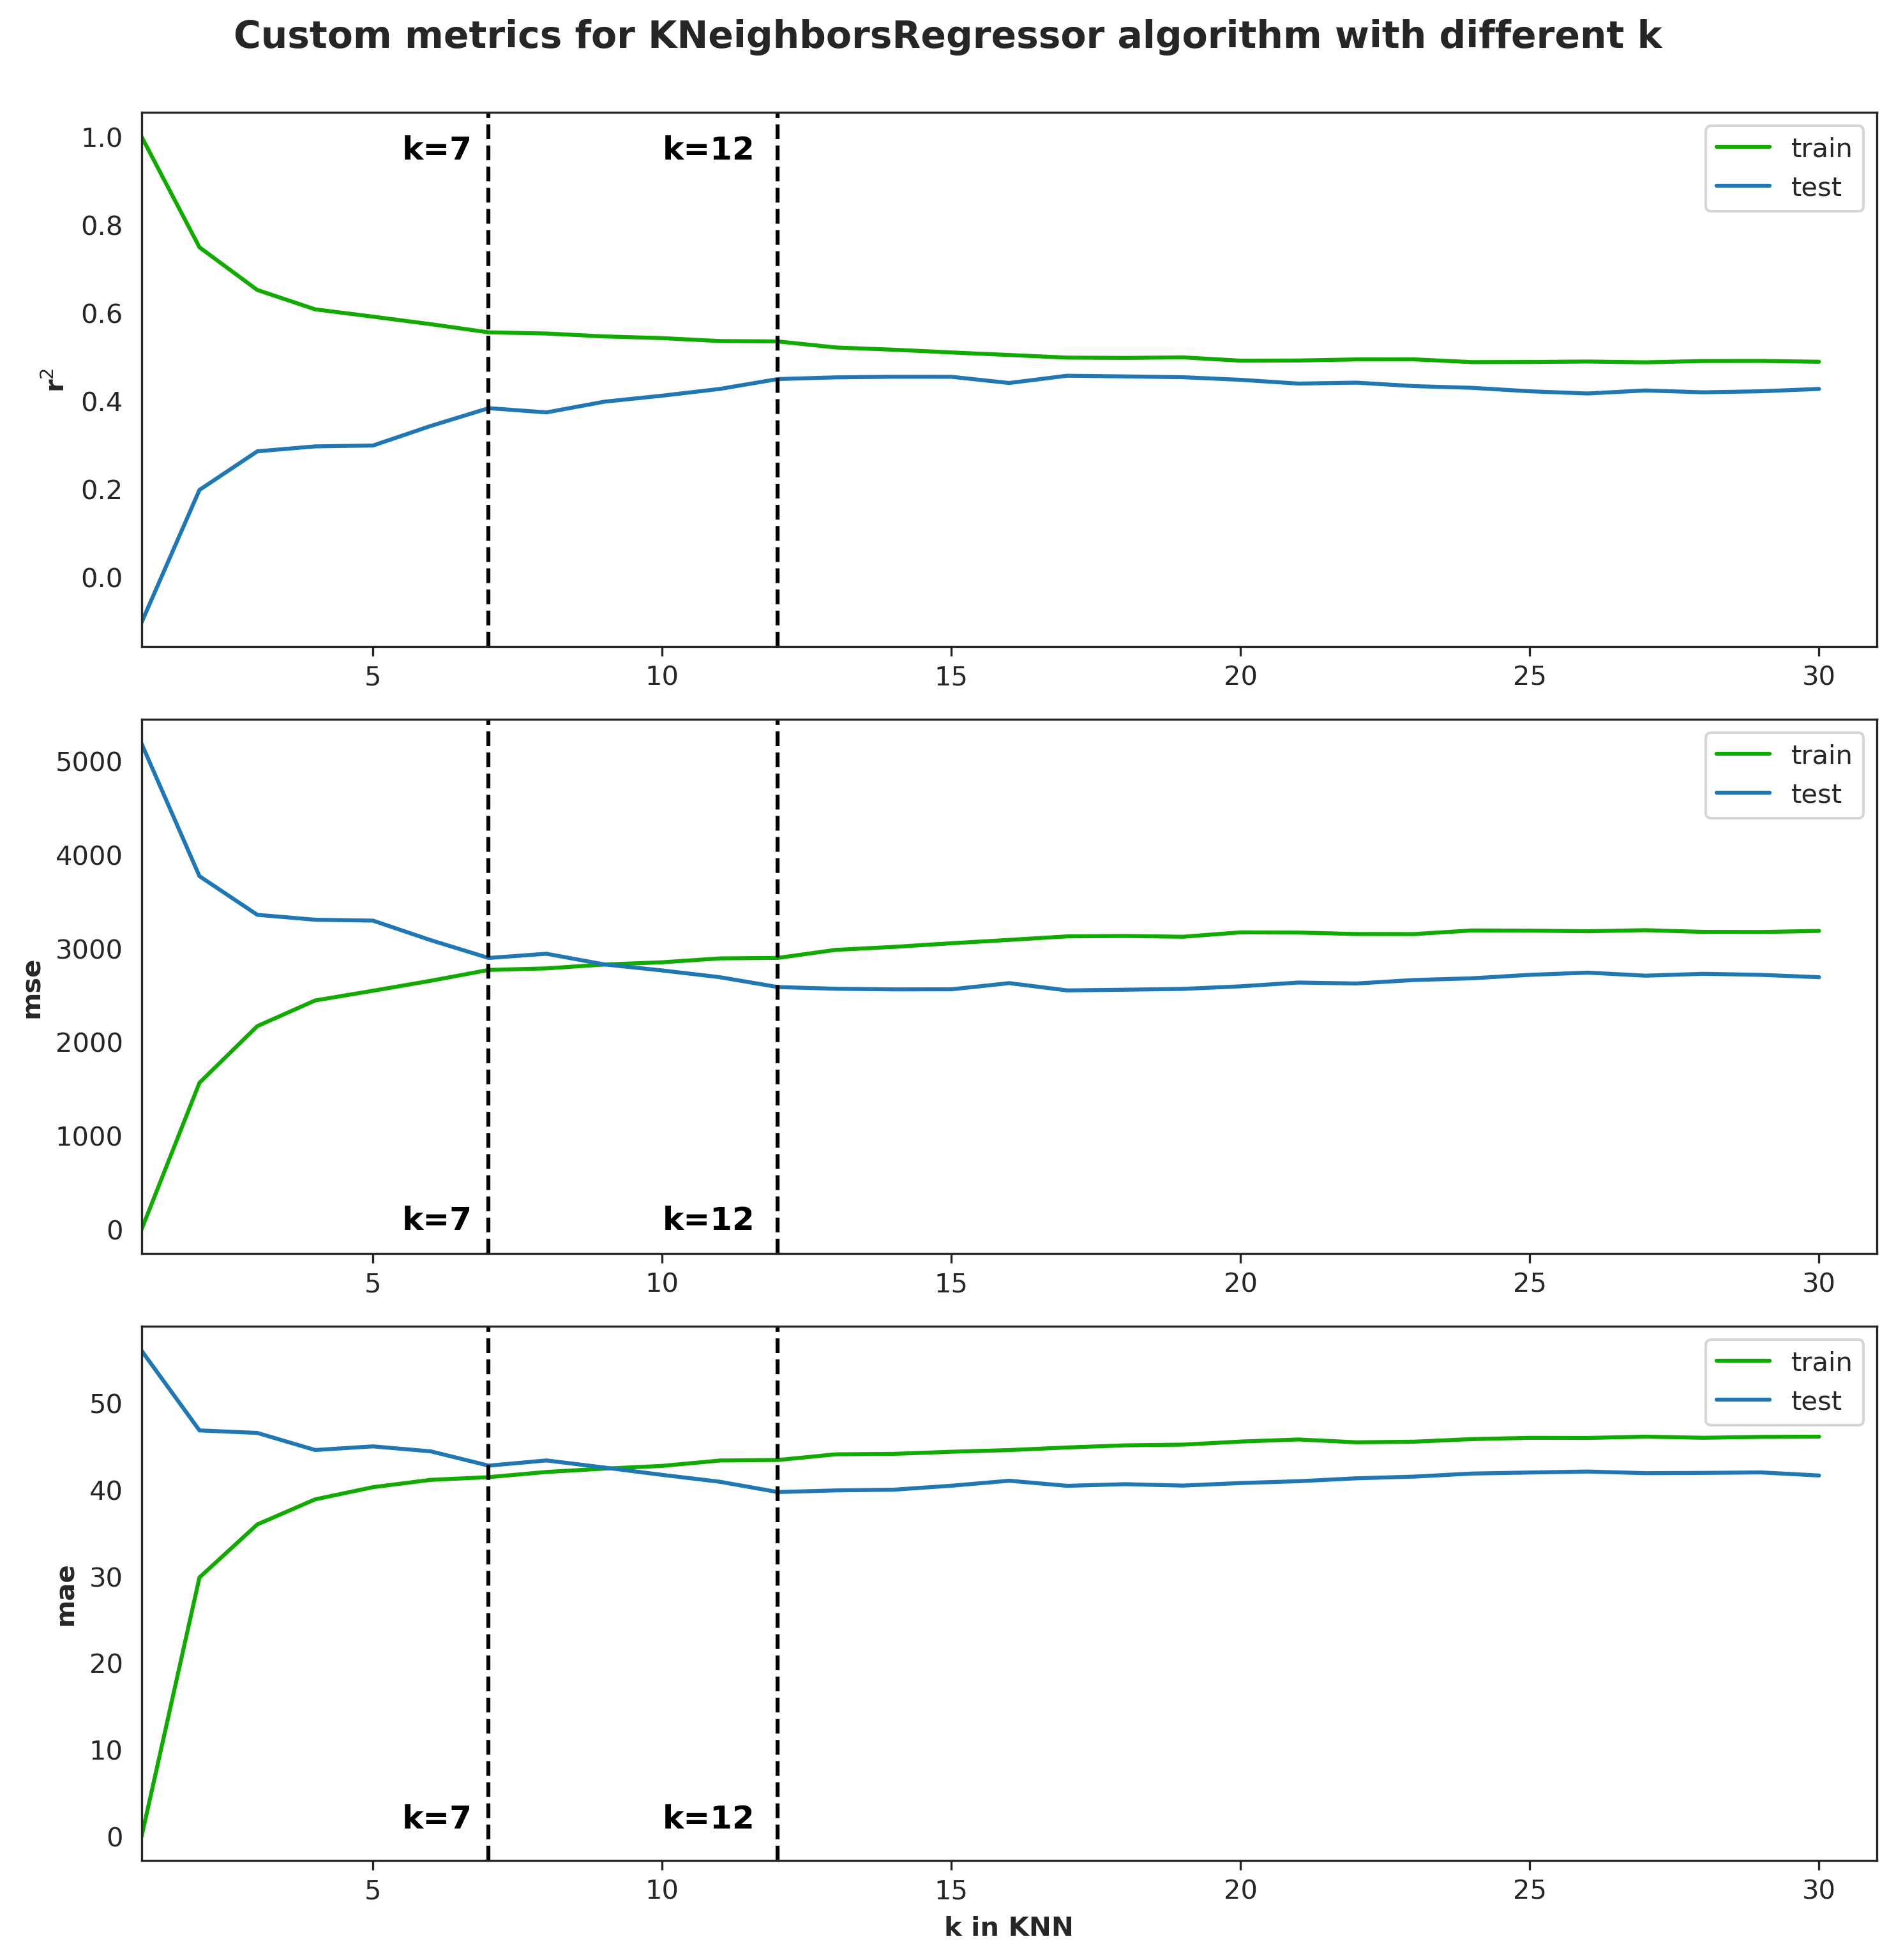

In [72]:
# with my metrics
fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(10, 10), dpi=300)
fig.suptitle("Custom metrics for KNeighborsRegressor algorithm with different k", 
             fontsize=14, fontweight='bold', y=1)    
fig.subplots_adjust(hspace=0.5)

for metric, ax in zip(train_metrics_reg.columns, axes.flat):
    ax.plot(params, train_metrics_reg[metric], label="train", color="#1a0")
    ax.plot(params, test_metrics_reg[metric], label="test")
    ax.set_ylabel(metric, fontweight='bold')
    ax.tick_params(axis='x', bottom=True)
    ax.axvline(x=7, color = 'black', linestyle='--')
    ax.axvline(x=12, color = 'black', linestyle='--')
    ax.set_xlim(1, 31)
    ax.legend(loc='upper right')
    ax.text(x=5.5, y=0.95, s="k=7", 
            fontdict={'fontsize': 12, 'fontweight': 'bold', 'color': 'black'})
    ax.text(x=10, y=0.95, s="k=12", 
            fontdict={'fontsize': 12, 'fontweight': 'bold', 'color': 'black'})

plt.tight_layout()
plt.xlabel("k in KNN", fontweight='bold')
plt.show();

In [73]:
# with sklearn metrics
def sk_find_best_k_reg(X_train, y_train, X_test, y_test, params):
    """
    Choose the best k for KNeighborsRegressor
    Arguments:
    X_train, np array (num_train_samples, num_features) - train data
    y_train, np array (num_train_samples) - train labels
    X_test, np array (num_test_samples, num_features) - test data
    y_test, np array (num_test_samples) - test labels
    params, list of hyperparameters for KNN, here it is list of k values
    
    Returns:
    train_metrics the list of metric values on train data set for each k in params
    test_metrics the list of metric values on test data set for each k in params
    """
    
    
    np.random.seed(SEED)
    train_metrics_reg = pd.DataFrame(columns=["r$^2$", "mse", "mae"])
    test_metrics_reg = pd.DataFrame(columns=["r$^2$", "mse", "mae"])
    
    for i, k in enumerate(params):
        knn_pipeline = Pipeline(steps=[
                                ("preprocessor", preprocessor),
                                ("knn_reg", KNeighborsRegressor(n_neighbors=k, 
                                                                n_jobs=4))])
        knn_pipeline.fit(X_train, y_train)
        
        # training model
        train_prediction_reg = knn_pipeline.predict(X_train)
        # testing model
        test_prediction_reg = knn_pipeline.predict(X_test)    
 
        # train model metrics
        r2 = r2_score(y_train, train_prediction_reg) 
        mse_score = mean_squared_error(y_train, train_prediction_reg)
        mae_score = mean_absolute_error(y_train, train_prediction_reg)
        train_metrics_reg.loc[i] = [r2, mse_score, mae_score]

        # test model metrics
        r2 = r2_score(y_test, test_prediction_reg) 
        mse_score = mean_squared_error(y_test, test_prediction_reg)
        mae_score = mean_absolute_error(y_test, test_prediction_reg)
        test_metrics_reg.loc[i] = [r2, mse_score, mae_score]
    return train_metrics_reg, test_metrics_reg

In [74]:
params = range(1, 31)
sk_train_metrics_reg, sk_test_metrics_reg = sk_find_best_k_reg(X_train, y_train, 
                                                               X_test, y_test, params)

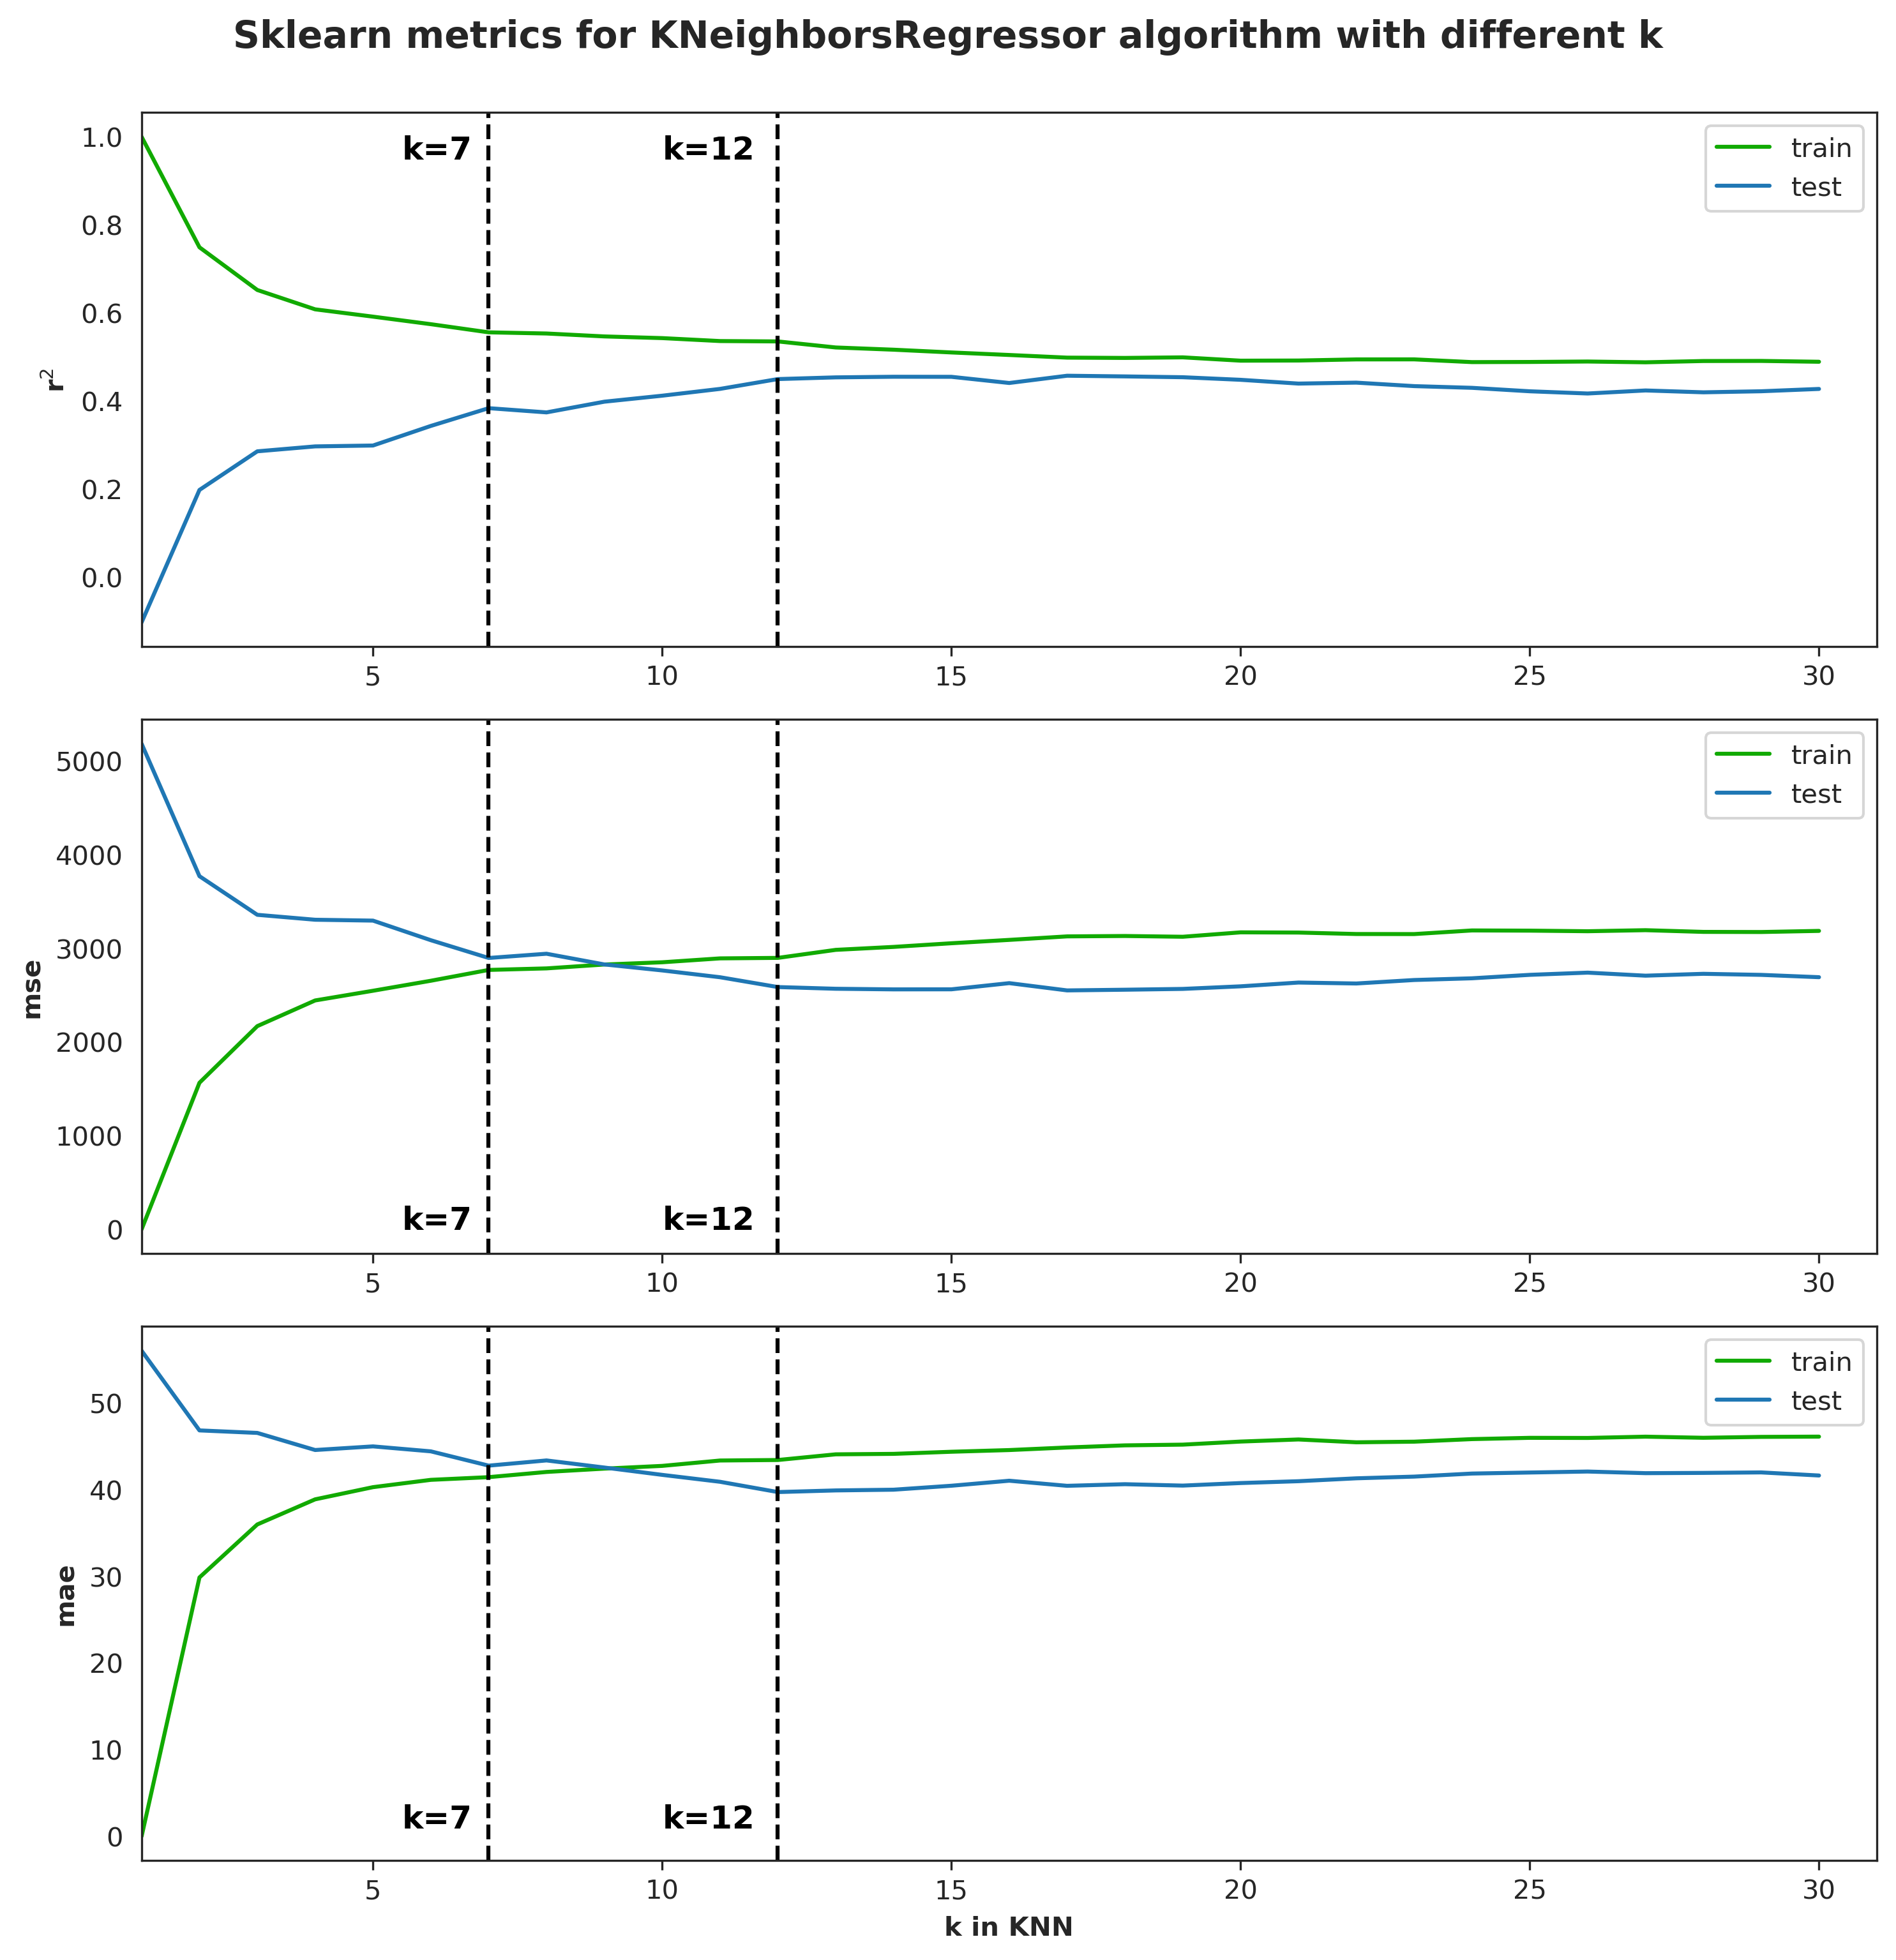

In [75]:
# with sklearn metrics
fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(10, 10), dpi=300)
fig.suptitle("Sklearn metrics for KNeighborsRegressor algorithm with different k", 
             fontsize=14, fontweight='bold', y=1)    
fig.subplots_adjust(hspace=0.5)

for metric, ax in zip(train_metrics_reg.columns, axes.flat):
    ax.plot(params, sk_train_metrics_reg[metric], label="train", color="#1a0")
    ax.plot(params, sk_test_metrics_reg[metric], label="test")
    ax.set_ylabel(metric, fontweight='bold')
    ax.tick_params(axis='x', bottom=True)
    ax.axvline(x=7, color = 'black', linestyle='--')
    ax.set_xlim(1, 31)
    ax.axvline(x=12, color = 'black', linestyle='--')
    ax.legend(loc='upper right')
    ax.text(x=5.5, y=0.95, s="k=7", 
            fontdict={'fontsize': 12, 'fontweight': 'bold', 'color': 'black'})
    ax.text(x=10, y=0.95, s="k=12", 
            fontdict={'fontsize': 12, 'fontweight': 'bold', 'color': 'black'})

plt.tight_layout()
plt.xlabel("k in KNN", fontweight='bold')
plt.show();

According to my metrics and imported from sklearn, I suggest that there are two good values for number of neighbors: *k=7*, or *k=12*. Let's look closer.

In [76]:
params = [7, 12]
train_metrics_reg, test_metrics_reg = find_best_k_reg(X_train, y_train, 
                                                      X_test, y_test, params)

In [77]:
test_metrics_reg

,r$^2$,mse,mae
0,0.383551,2897.584270,42.781701
1,0.449633,2586.972924,39.731273


**Conclusions:**

- *Which number of neighbors (*k*) should be chosen?*

I prefer to use seven neighbors for kNeighborRegression since, according to the data from the custom and sklearn metrics, the metrics ($R^2$, MSE, and MAE) is one of the best for test X values. Also, it should be mentioned that the highest quality for this regression model coud be archived with *k=12* but there is a little loss in quality for model with *k=7*.

### 3. Социализация (0.5 доп. балла)

Так как у нас теперь большая группа, то было бы здорово всем познакомиться получше (так как выпускной не за горами). Соберитесь с одногруппниками в зуме (желательно, чтобы были люди и с Онлайна, и с Питера), познакомьтесь, а сюда прикрепите скриншот с камерами всех участников.

## Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз. 

**Ваши мысли:**

Я не плачу, это просто слёзы.
Но на самом деле, было интересно, больно, но интересно:)